# **Notebook Ensemble**
- Event-masked PRL-NN --> LB 0.691
- CIBMTR Yunbase --> LB 0.689
- CIBMTR | EDA & Ensemble Model --> LB 0.689

---

# **Event-masked PRL-NN**

https://www.kaggle.com/code/albansteff/event-masked-prl-nn

### Refactoring Pairwise Ranking Network

This notebook focuses on adding an event-predicted mask to shift the risk of these subjects. The original idea comes from [this notebook](https://www.kaggle.com/code/kendontcare11/public-classifier-cat-xgb-lb-0-688)

In [1]:
!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_lightning-2.4.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/torchmetrics-1.5.2-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabnet-4.1.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/einops-0.7.0-py3-none-any.whl
!pip install -q /kaggle/input/download-lightning-and-pytorch-tabular/pytorch_tabular-1.1.1-py2.py3-none-any.whl

  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.


## XGB Classifier to mask further predictions

In [2]:
from pathlib import Path
from metric import score
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')

ROOT_DATA_PATH = Path(r"/kaggle/input/equity-post-HCT-survival-predictions")

pd.set_option('display.max_columns', 100)

train = pd.read_csv(ROOT_DATA_PATH.joinpath("train.csv"))
test = pd.read_csv(ROOT_DATA_PATH.joinpath("test.csv"))

CATEGORICAL_VARIABLES = [
    # Graft and HCT reasons
    'dri_score', 'graft_type', 'prod_type', 'prim_disease_hct',

    # Patient health status (risk factors)
    'psych_disturb', 'diabetes', 'arrhythmia', 'vent_hist', 'renal_issue', 'pulm_moderate',
    'pulm_severe', 'obesity', 'hepatic_mild', 'hepatic_severe', 'peptic_ulcer', 'rheum_issue',
    'cardiac', 'prior_tumor', 'mrd_hct', 'tbi_status', 'cyto_score', 'cyto_score_detail', 

    # Patient demographics
    'ethnicity', 'race_group',

    # Biological matching with donor
    'sex_match', 'donor_related', 'cmv_status', 'tce_imm_match', 'tce_match', 'tce_div_match',

    # Medication/operation related data
    'melphalan_dose', 'rituximab', 'gvhd_proph', 'in_vivo_tcd', 'conditioning_intensity'
]

HLA_COLUMNS = [
    'hla_match_a_low', 'hla_match_a_high',
    'hla_match_b_low', 'hla_match_b_high',
    'hla_match_c_low', 'hla_match_c_high',
    'hla_match_dqb1_low', 'hla_match_dqb1_high',
    'hla_match_drb1_low', 'hla_match_drb1_high',
    
    # Matching at HLA-A(low), -B(low), -DRB1(high)
    'hla_nmdp_6',
    # Matching at HLA-A,-B,-DRB1 (low or high)
    'hla_low_res_6', 'hla_high_res_6',
    # Matching at HLA-A, -B, -C, -DRB1 (low or high)
    'hla_low_res_8', 'hla_high_res_8',
    # Matching at HLA-A, -B, -C, -DRB1, -DQB1 (low or high)
    'hla_low_res_10', 'hla_high_res_10'
]

OTHER_NUMERICAL_VARIABLES = ['year_hct', 'donor_age', 'age_at_hct', 'comorbidity_score', 'karnofsky_score']
NUMERICAL_VARIABLES = HLA_COLUMNS + OTHER_NUMERICAL_VARIABLES

TARGET_VARIABLES = ['efs_time', 'efs']
ID_COLUMN = ["ID"]


def preprocess_data(df):
    df[CATEGORICAL_VARIABLES] = df[CATEGORICAL_VARIABLES].fillna("Unknown")
    df[OTHER_NUMERICAL_VARIABLES] = df[OTHER_NUMERICAL_VARIABLES].fillna(df[OTHER_NUMERICAL_VARIABLES].median())

    return df

train = preprocess_data(train)
test = preprocess_data(test)


def features_engineering(df):
    # Change year_hct to relative year from 2000
    df['year_hct'] = df['year_hct'] - 2000
    
    return df


train = features_engineering(train)
test = features_engineering(test)

train[CATEGORICAL_VARIABLES] = train[CATEGORICAL_VARIABLES].astype('category')
test[CATEGORICAL_VARIABLES] = test[CATEGORICAL_VARIABLES].astype('category')

FEATURES = train.drop(columns=['ID', 'efs', 'efs_time']).columns.tolist()

In [3]:
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_xgb = np.zeros(len(train))
pred_efs = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train, train["efs"])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, "efs"]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, "efs"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBClassifier(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.7129400756425178, 
        subsample=0.8185881823156917, 
        n_estimators=20_000, 
        learning_rate=0.04425768131771064,  
        eval_metric="auc", 
        early_stopping_rounds=50, 
        objective='binary:logistic',
        scale_pos_weight=1.5379160847615545,  
        min_child_weight=4,
        enable_categorical=True,
        gamma=3.1330719334577584
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100
    )

    # INFER OOF (Probabilities -> Binary)
    oof_xgb[test_index] = (model_xgb.predict_proba(x_valid)[:, 1] > 0.5).astype(int)
    # INFER TEST (Probabilities -> Average Probs)
    pred_efs += model_xgb.predict_proba(x_test)[:, 1]

# COMPUTE AVERAGE TEST PREDS
pred_efs = (pred_efs / FOLDS > 0.5).astype(int)

# EVALUATE PERFORMANCE
accuracy = accuracy_score(train["efs"], oof_xgb)
f1 = f1_score(train["efs"], oof_xgb)
roc_auc = roc_auc_score(train["efs"], oof_xgb)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Using XGBoost version 2.0.3
#########################
### Fold 1
#########################
[0]	validation_0-auc:0.65144
[100]	validation_0-auc:0.72648
[200]	validation_0-auc:0.73447
[300]	validation_0-auc:0.73889
[400]	validation_0-auc:0.74073
[500]	validation_0-auc:0.74241
[595]	validation_0-auc:0.74261
#########################
### Fold 2
#########################
[0]	validation_0-auc:0.67116
[100]	validation_0-auc:0.75073
[200]	validation_0-auc:0.75850
[300]	validation_0-auc:0.76222
[400]	validation_0-auc:0.76403
[500]	validation_0-auc:0.76548
[590]	validation_0-auc:0.76578
#########################
### Fold 3
#########################
[0]	validation_0-auc:0.67246
[100]	validation_0-auc:0.74840
[200]	validation_0-auc:0.75777
[300]	validation_0-auc:0.76097
[400]	validation_0-auc:0.76271
[500]	validation_0-auc:0.76388
[600]	validation_0-auc:0.76426
[684]	validation_0-auc:0.76414
#########################
### Fold 4
#########################
[0]	validation_0-auc:0.66194
[100]	validatio

## Prepare data

Below are a few utility functions to load and prepare the data for training with pytorch.

In [4]:
import numpy as np
import pandas as pd
import torch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import TensorDataset
from warnings import filterwarnings

filterwarnings('ignore')


def get_X_cat(df, cat_cols, transformers=None):
    """
    Apply a specific categorical data transformer or a LabelEncoder if None.
    """
    if transformers is None:
        transformers = [LabelEncoder().fit(df[col]) for col in cat_cols]
    return transformers, np.array(
        [transformer.transform(df[col]) for col, transformer in zip(cat_cols, transformers)]
    ).T


def preprocess_data(train, val):
    """
    Standardize numerical variables and transform (Label-encode) categoricals.
    Fill NA values with mean for numerical.
    Create torch dataloaders to prepare data for training and evaluation.
    """
    X_cat_train, X_cat_val, numerical, transformers = get_categoricals(train, val)
    scaler = StandardScaler()
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    X_num_train = imp.fit_transform(train[numerical])
    X_num_train = scaler.fit_transform(X_num_train)
    X_num_val = imp.transform(val[numerical])
    X_num_val = scaler.transform(X_num_val)
    dl_train = init_dl(X_cat_train, X_num_train, train, training=True)
    dl_val = init_dl(X_cat_val, X_num_val, val)
    return X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers


def get_categoricals(train, val):
    """
    Remove constant categorical columns and transform them using LabelEncoder.
    Return the label-transformers for each categorical column, categorical dataframes and numerical columns.
    """
    categorical_cols, numerical = get_feature_types(train)
    remove = []
    for col in categorical_cols:
        if train[col].nunique() == 1:
            remove.append(col)
        ind = ~val[col].isin(train[col])
        if ind.any():
            val.loc[ind, col] = np.nan
    categorical_cols = [col for col in categorical_cols if col not in remove]
    transformers, X_cat_train = get_X_cat(train, categorical_cols)
    _, X_cat_val = get_X_cat(val, categorical_cols, transformers)
    return X_cat_train, X_cat_val, numerical, transformers


def init_dl(X_cat, X_num, df, training=False):
    """
    Initialize data loaders with 4 dimensions : categorical dataframe, numerical dataframe and target values (efs and efs_time).
    Notice that efs_time is log-transformed.
    Fix batch size to 2048 and return dataloader for training or validation depending on training value.
    """
    ds_train = TensorDataset(
        torch.tensor(X_cat, dtype=torch.long),
        torch.tensor(X_num, dtype=torch.float32),
        torch.tensor(df.efs_time.values, dtype=torch.float32).log(),
        torch.tensor(df.efs.values, dtype=torch.long)
    )
    bs = 2048
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=bs, pin_memory=True, shuffle=training)
    return dl_train


def get_feature_types(train):
    """
    Utility function to return categorical and numerical column names.
    """
    categorical_cols = [col for i, col in enumerate(train.columns) if ((train[col].dtype == "object") | (2 < train[col].nunique() < 25))]
    RMV = ["ID", "efs", "efs_time", "y"]
    FEATURES = [c for c in train.columns if not c in RMV]
    numerical = [i for i in FEATURES if i not in categorical_cols]
    return categorical_cols, numerical


def add_features(df):
    """
    Create some new features to help the model focus on specific patterns.
    """
    # sex_match = df.sex_match.astype(str)
    # sex_match = sex_match.str.split("-").str[0] == sex_match.str.split("-").str[1]
    # df['sex_match_bool'] = sex_match
    # df.loc[df.sex_match.isna(), 'sex_match_bool'] = np.nan
    # df['big_age'] = df.age_at_hct > 16
    # df.loc[df.year_hct == 2019, 'year_hct'] = 2020
    df['is_cyto_score_same'] = (df['cyto_score'] == df['cyto_score_detail']).astype(int)
    # df['strange_age'] = df.age_at_hct == 0.044
    # df['age_bin'] = pd.cut(df.age_at_hct, [0, 0.0441, 16, 30, 50, 100])
    # df['age_ts'] = df.age_at_hct / df.donor_age
    df['year_hct'] -= 2000
    
    return df


def load_data():
    """
    Load data and add features.
    """
    test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
    test = add_features(test)
    print("Test shape:", test.shape)
    train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
    train = add_features(train)
    print("Train shape:", train.shape)
    return test, train


## Define models with pairwise ranking loss

The model is defined in 3 steps :
* Embedding class for categorical data
* MLP for numerical and categorical data
* Final model trained with pairwise ranking loss with selection of valid pairs

In [5]:
import functools
from typing import List

import pytorch_lightning as pl
import numpy as np
import torch
from lifelines.utils import concordance_index
from pytorch_lightning.cli import ReduceLROnPlateau
from pytorch_tabular.models.common.layers import ODST
from torch import nn
from pytorch_lightning.utilities import grad_norm


class CatEmbeddings(nn.Module):
    """
    Embedding module for the categorical dataframe.
    """
    def __init__(
        self,
        projection_dim: int,
        categorical_cardinality: List[int],
        embedding_dim: int
    ):
        """
        projection_dim: The dimension of the final output after projecting the concatenated embeddings into a lower-dimensional space.
        categorical_cardinality: A list where each element represents the number of unique categories (cardinality) in each categorical feature.
        embedding_dim: The size of the embedding space for each categorical feature.
        self.embeddings: list of embedding layers for each categorical feature.
        self.projection: sequential neural network that goes from the embedding to the output projection dimension with GELU activation.
        """
        super(CatEmbeddings, self).__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in categorical_cardinality
        ])
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim * len(categorical_cardinality), projection_dim),
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim)
        )

    def forward(self, x_cat):
        """
        Apply the projection on concatened embeddings that contains all categorical features.
        """
        x_cat = [embedding(x_cat[:, i]) for i, embedding in enumerate(self.embeddings)]
        x_cat = torch.cat(x_cat, dim=1)
        return self.projection(x_cat)


class NN(nn.Module):
    """
    Train a model on both categorical embeddings and numerical data.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            dropout: float = 0
    ):
        """
        continuous_dim: The number of continuous features.
        categorical_cardinality: A list of integers representing the number of unique categories in each categorical feature.
        embedding_dim: The dimensionality of the embedding space for each categorical feature.
        projection_dim: The size of the projected output space for the categorical embeddings.
        hidden_dim: The number of neurons in the hidden layer of the MLP.
        dropout: The dropout rate applied in the network.
        self.embeddings: previous embeddings for categorical data.
        self.mlp: defines an MLP model with an ODST layer followed by batch normalization and dropout.
        self.out: linear output layer that maps the output of the MLP to a single value
        self.dropout: defines dropout
        Weights initialization with xavier normal algorithm and biases with zeros.
        """
        super(NN, self).__init__()
        self.embeddings = CatEmbeddings(projection_dim, categorical_cardinality, embedding_dim)
        self.mlp = nn.Sequential(
            ODST(projection_dim + continuous_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        self.out = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

        # initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_cat, x_cont):
        """
        Create embedding layers for categorical data, concatenate with continous variables.
        Add dropout and goes through MLP and return raw output and 1-dimensional output as well.
        """
        x = self.embeddings(x_cat)
        x = torch.cat([x, x_cont], dim=1)
        x = self.dropout(x)
        x = self.mlp(x)
        return self.out(x), x


@functools.lru_cache
def combinations(N):
    """
    calculates all possible 2-combinations (pairs) of a tensor of indices from 0 to N-1, 
    and caches the result using functools.lru_cache for optimization
    """
    ind = torch.arange(N)
    comb = torch.combinations(ind, r=2)
    return comb.cuda()


class LitNN(pl.LightningModule):
    """
    Main Model creation and losses definition to fully train the model.
    """
    def __init__(
            self,
            continuous_dim: int,
            categorical_cardinality: List[int],
            embedding_dim: int,
            projection_dim: int,
            hidden_dim: int,
            lr: float = 1e-3,
            dropout: float = 0.2,
            weight_decay: float = 1e-3,
            aux_weight: float = 0.1,
            margin: float = 0.5,
            race_index: int = 0
    ):
        """
        continuous_dim: The number of continuous input features.
        categorical_cardinality: A list of integers, where each element corresponds to the number of unique categories for each categorical feature.
        embedding_dim: The dimension of the embeddings for the categorical features.
        projection_dim: The dimension of the projected space after embedding concatenation.
        hidden_dim: The size of the hidden layers in the feedforward network (MLP).
        lr: The learning rate for the optimizer.
        dropout: Dropout probability to avoid overfitting.
        weight_decay: The L2 regularization term for the optimizer.
        aux_weight: Weight used for auxiliary tasks.
        margin: Margin used in some loss functions.
        race_index: An index that refer to race_group in the input data.
        """
        super(LitNN, self).__init__()
        self.save_hyperparameters()

        # Creates an instance of the NN model defined above
        self.model = NN(
            continuous_dim=self.hparams.continuous_dim,
            categorical_cardinality=self.hparams.categorical_cardinality,
            embedding_dim=self.hparams.embedding_dim,
            projection_dim=self.hparams.projection_dim,
            hidden_dim=self.hparams.hidden_dim,
            dropout=self.hparams.dropout
        )
        self.targets = []

        # Defines a small feedforward neural network that performs an auxiliary task with 1-dimensional output
        self.aux_cls = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim // 3),
            nn.GELU(),
            nn.Linear(self.hparams.hidden_dim // 3, 1)
        )

    def on_before_optimizer_step(self, optimizer):
        """
        Compute the 2-norm for each layer
        If using mixed precision, the gradients are already unscaled here
        """
        norms = grad_norm(self.model, norm_type=2)
        self.log_dict(norms)

    def forward(self, x_cat, x_cont):
        """
        Forward pass that outputs the 1-dimensional prediction and the embeddings (raw output)
        """
        x, emb = self.model(x_cat, x_cont)
        return x.squeeze(1), emb

    def training_step(self, batch, batch_idx):
        """
        defines how the model processes each batch of data during training.
        A batch is a combination of : categorical data, continuous data, efs_time (y) and efs event.
        y_hat is the efs_time prediction on all data and aux_pred is auxiliary prediction on embeddings.
        Calculates loss and race_group loss on full data.
        Auxiliary loss is calculated with an event mask, ignoring efs=0 predictions and taking the average.
        Returns loss and aux_loss multiplied by weight defined above.
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        aux_pred = self.aux_cls(emb).squeeze(1)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        aux_loss = nn.functional.mse_loss(aux_pred, y, reduction='none')
        aux_mask = efs == 1
        aux_loss = (aux_loss * aux_mask).sum() / aux_mask.sum()
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("race_loss", race_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        self.log("aux_loss", aux_loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
        return loss + aux_loss * self.hparams.aux_weight

    def get_full_loss(self, efs, x_cat, y, y_hat):
        """
        Output loss and race_group loss.
        """
        loss = self.calc_loss(y, y_hat, efs)
        race_loss = self.get_race_losses(efs, x_cat, y, y_hat)
        loss += 0.1 * race_loss
        return loss, race_loss

    def get_race_losses(self, efs, x_cat, y, y_hat):
        """
        Calculate loss for each race_group based on deviation/variance.
        """
        races = torch.unique(x_cat[:, self.hparams.race_index])
        race_losses = []
        for race in races:
            ind = x_cat[:, self.hparams.race_index] == race
            race_losses.append(self.calc_loss(y[ind], y_hat[ind], efs[ind]))
        race_loss = sum(race_losses) / len(race_losses)
        races_loss_std = sum((r - race_loss)**2 for r in race_losses) / len(race_losses)
        return torch.sqrt(races_loss_std)

    def calc_loss(self, y, y_hat, efs):
        """
        Most important part of the model : loss function used for training.
        We face survival data with event indicators along with time-to-event.

        This function computes the main loss by the following the steps :
        * create all data pairs with "combinations" function (= all "two subjects" combinations)
        * make sure that we have at least 1 event in each pair
        * convert y to +1 or -1 depending on the correct ranking
        * loss is computed using a margin-based hinge loss
        * mask is applied to ensure only valid pairs are being used (censored data can't be ranked with event in some cases)
        * average loss on all pairs is returned
        """
        N = y.shape[0]
        comb = combinations(N)
        comb = comb[(efs[comb[:, 0]] == 1) | (efs[comb[:, 1]] == 1)]
        pred_left = y_hat[comb[:, 0]]
        pred_right = y_hat[comb[:, 1]]
        y_left = y[comb[:, 0]]
        y_right = y[comb[:, 1]]
        y = 2 * (y_left > y_right).int() - 1
        loss = nn.functional.relu(-y * (pred_left - pred_right) + self.hparams.margin)
        mask = self.get_mask(comb, efs, y_left, y_right)
        loss = (loss.double() * (mask.double())).sum() / mask.sum()
        return loss

    def get_mask(self, comb, efs, y_left, y_right):
        """
        Defines all invalid comparisons :
        * Case 1: "Left outlived Right" but Right is censored
        * Case 2: "Right outlived Left" but Left is censored
        Masks for case 1 and case 2 are combined using |= operator and inverted using ~ to create a "valid pair mask"
        """
        left_outlived = y_left >= y_right
        left_1_right_0 = (efs[comb[:, 0]] == 1) & (efs[comb[:, 1]] == 0)
        mask2 = (left_outlived & left_1_right_0)
        right_outlived = y_right >= y_left
        right_1_left_0 = (efs[comb[:, 1]] == 1) & (efs[comb[:, 0]] == 0)
        mask2 |= (right_outlived & right_1_left_0)
        mask2 = ~mask2
        mask = mask2
        return mask

    def validation_step(self, batch, batch_idx):
        """
        This method defines how the model processes each batch during validation
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_validation_epoch_end(self):
        """
        At the end of the validation epoch, it computes and logs the concordance index
        """
        cindex, metric = self._calc_cindex()
        self.log("cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()

    def _calc_cindex(self):
        """
        Calculate c-index accounting for each race_group or global.
        """
        y = torch.cat([t[0] for t in self.targets]).cpu().numpy()
        y_hat = torch.cat([t[1] for t in self.targets]).cpu().numpy()
        efs = torch.cat([t[2] for t in self.targets]).cpu().numpy()
        races = torch.cat([t[3] for t in self.targets]).cpu().numpy()
        metric = self._metric(efs, races, y, y_hat)
        cindex = concordance_index(y, y_hat, efs)
        return cindex, metric

    def _metric(self, efs, races, y, y_hat):
        """
        Calculate c-index accounting for each race_group
        """
        metric_list = []
        for race in np.unique(races):
            y_ = y[races == race]
            y_hat_ = y_hat[races == race]
            efs_ = efs[races == race]
            metric_list.append(concordance_index(y_, y_hat_, efs_))
        metric = float(np.mean(metric_list) - np.sqrt(np.var(metric_list)))
        return metric

    def test_step(self, batch, batch_idx):
        """
        Same as training step but to log test data
        """
        x_cat, x_cont, y, efs = batch
        y_hat, emb = self(x_cat, x_cont)
        loss, race_loss = self.get_full_loss(efs, x_cat, y, y_hat)
        self.targets.append([y, y_hat.detach(), efs, x_cat[:, self.hparams.race_index]])
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self) -> None:
        """
        At the end of the test epoch, calculates and logs the concordance index for the test set
        """
        cindex, metric = self._calc_cindex()
        self.log("test_cindex", metric, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_cindex_simple", cindex, on_epoch=True, prog_bar=True, logger=True)
        self.targets.clear()


    def configure_optimizers(self):
        """
        configures the optimizer and learning rate scheduler:
        * Optimizer: Adam optimizer with weight decay (L2 regularization).
        * Scheduler: Cosine Annealing scheduler, which adjusts the learning rate according to a cosine curve.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler_config = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=45,
                eta_min=6e-3
            ),
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }

        return {"optimizer": optimizer, "lr_scheduler": scheduler_config}

In [6]:
import json
import pytorch_lightning as pl
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import torch
from pytorch_lightning.callbacks import LearningRateMonitor, TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from sklearn.model_selection import StratifiedKFold

pl.seed_everything(42)

def main(hparams):
    """
    Main function to train the model.
    The steps are as following :
    * load data and fill efs and efs time for test data with 1
    * initialize pred array with 0
    * get categorical and numerical columns
    * split the train data on the stratified criterion : race_group * newborns yes/no
    * preprocess the fold data (create dataloaders)
    * train the model and create final submission output
    """
    test, train_original = load_data()
    test['efs_time'] = 1
    test['efs'] = 1
    oof_nn_pairwise = np.zeros(len(train_original))
    test_pred = np.zeros(test.shape[0])
    categorical_cols, numerical = get_feature_types(train_original)
    kf = StratifiedKFold(n_splits=5, shuffle=True, )
    for i, (train_index, test_index) in enumerate(
        kf.split(
            train_original, train_original.race_group.astype(str) + (train_original.age_at_hct == 0.044).astype(str)
        )
    ):
        tt = train_original.copy()
        train = tt.iloc[train_index]
        val = tt.iloc[test_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, val)
        model = train_final(X_num_train, dl_train, dl_val, transformers, categorical_cols=categorical_cols)
        oof_pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        oof_nn_pairwise[test_index] = oof_pred.detach().cpu().numpy()
        # Create submission
        train = tt.iloc[train_index]
        X_cat_val, X_num_train, X_num_val, dl_train, dl_val, transformers = preprocess_data(train, test)
        pred, _ = model.cuda().eval()(
            torch.tensor(X_cat_val, dtype=torch.long).cuda(),
            torch.tensor(X_num_val, dtype=torch.float32).cuda()
        )
        test_pred += pred.detach().cpu().numpy()
        
    
    return -test_pred, -oof_nn_pairwise



def train_final(X_num_train, dl_train, dl_val, transformers, hparams=None, categorical_cols=None):
    """
    Defines model hyperparameters and fit the model.
    """
    if hparams is None:
        hparams = {
            "embedding_dim": 16,
            "projection_dim": 112,
            "hidden_dim": 56,
            "lr": 0.06464861983337984,
            "dropout": 0.05463240181423116,
            "aux_weight": 0.26545778308743806,
            "margin": 0.2588153271003354,
            "weight_decay": 0.0002773544957610778
        }
    model = LitNN(
        continuous_dim=X_num_train.shape[1],
        categorical_cardinality=[len(t.classes_) for t in transformers],
        race_index=categorical_cols.index("race_group"),
        **hparams
    )
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", save_top_k=1)
    trainer = pl.Trainer(
        accelerator='cuda',
        max_epochs=60,
        log_every_n_steps=6,
        callbacks=[
            checkpoint_callback,
            LearningRateMonitor(logging_interval='epoch'),
            TQDMProgressBar(),
            StochasticWeightAveraging(swa_lrs=1e-5, swa_epoch_start=45, annealing_epochs=15)
        ],
    )
    trainer.fit(model, dl_train)
    trainer.test(model, dl_val)
    return model.eval()

In [7]:
hparams = None
pairwise_ranking_pred, pairwise_ranking_oof = main(hparams)

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN CV =",m)

# Update predictions with classifier mask
pairwise_ranking_oof[oof_xgb == 1] += 0.2
y_pred["prediction"] = pairwise_ranking_oof
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nPairwise ranking NN with classifier mask -> CV =",m)

pairwise_ranking_pred[pred_efs == 1] += 0.2

Test shape: (3, 59)
Train shape: (28800, 61)


Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6752110719680786     │
│    test_cindex_simple     │    0.6917092204093933     │
│         test_loss         │    0.18244810805620612    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6762855648994446     │
│    test_cindex_simple     │     0.685375452041626     │
│         test_loss         │    0.1851053912198791     │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6850398778915405     │
│    test_cindex_simple     │    0.6931629180908203     │
│         test_loss         │    0.18174725516785187    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │     0.683285117149353     │
│    test_cindex_simple     │     0.69674152135849      │
│         test_loss         │    0.17937272023554932    │
└───────────────────────────┴───────────────────────────┘

Training: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_cindex        │    0.6708257794380188     │
│    test_cindex_simple     │    0.6784462332725525     │
│         test_loss         │    0.19040912343272312    │
└───────────────────────────┴───────────────────────────┘


Pairwise ranking NN CV = 0.6799316925429553

Pairwise ranking NN with classifier mask -> CV = 0.6809851220120042


In [8]:
subm_data = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
subm_data['prediction'] = pairwise_ranking_pred
subm_data.to_csv('submission2.csv', index=False)

---

# **CIBMTR Yunbase**

https://www.kaggle.com/code/yunsuxiaozi/cibmtr-yunbase

In [9]:
!pip install -q --requirement /kaggle/input/yunbase/Yunbase/requirements.txt  \
--no-index --find-links file:/kaggle/input/yunbase/

!pip install -q /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install -q /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install -q /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

  Preparing metadata (setup.py) ... done


In [10]:
source_file_path = '/kaggle/input/yunbase/Yunbase/baseline.py'
target_file_path = '/kaggle/working/baseline.py'
with open(source_file_path, 'r', encoding='utf-8') as file:
    content = file.read()
with open(target_file_path, 'w', encoding='utf-8') as file:
    file.write(content)

In [11]:
from baseline import Yunbase
import pandas as pd#read csv,parquet
import numpy as np#for scientific computation of matrices
from  lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBRegressor,XGBClassifier
from lifelines import KaplanMeierFitter
import warnings#avoid some negligible errors
#The filterwarnings () method is used to set warning filters, which can control the output method and level of warning information.
warnings.filterwarnings('ignore')
import random#provide some function to generate random_seed.
#set random seed,to make sure model can be recurrented.
def seed_everything(seed):
    np.random.seed(seed)#numpy's random seed
    random.seed(seed)#python built-in random seed
seed_everything(seed=2025)

train=pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
test=pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
train_solution=train[['ID','efs','efs_time','race_group']].copy()

def logit(p):
    return np.log(p) - np.log(1 - p)
max_efs_time,min_efs_time=80,-100
train['efs_time']=train['efs_time']/(max_efs_time-min_efs_time)
train['efs_time']=train['efs_time'].apply(lambda x:logit(x))
train['efs_time']+=10
print(train['efs_time'].max(),train['efs_time'].min())

race2weight={'American Indian or Alaska Native':0.68,
'Asian':0.7,'Black or African-American':0.67,
'More than one race':0.68,
'Native Hawaiian or other Pacific Islander':0.66,
'White':0.64}
train['weight']=0.5*train['efs']+0.5
train['raceweight']=train['race_group'].apply(lambda x:race2weight.get(x,1))
train['weight']=train['weight']/train['raceweight']
train.drop(['raceweight'],axis=1,inplace=True)

train.head()

11.911759296425227 3.709282073471571


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,weight
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,8.821439,0.735294
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,6.374929,1.428571
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,7.908862,0.735294
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,10.276164,0.781250
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,7.687924,0.735294


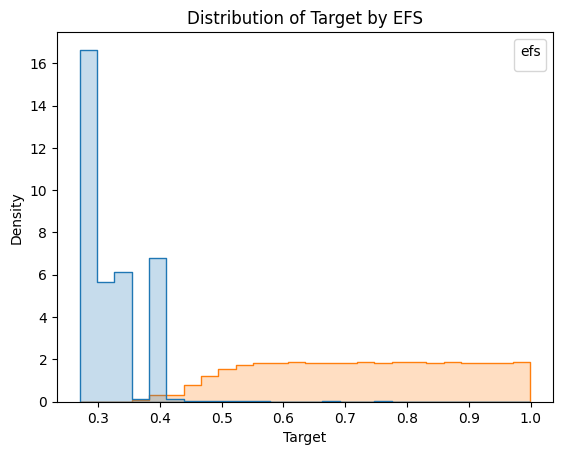

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):

    kmf = KaplanMeierFitter()
    
    kmf.fit(df[time_col], event_observed=df[event_col])
    
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()

    return survival_probabilities

race_group=sorted(train['race_group'].unique())
for race in race_group:
    train.loc[train['race_group']==race,"target"] = transform_survival_probability(train[train['race_group']==race], time_col='efs_time', event_col='efs')
    gap=0.7*(train.loc[(train['race_group']==race)&(train['efs']==0)]['target'].max()-train.loc[(train['race_group']==race)&(train['efs']==1)]['target'].min())/2
    train.loc[(train['race_group']==race)&(train['efs']==0),'target']-=gap

sns.histplot(data=train, x='target', hue='efs', element='step', stat='density', common_norm=False)
plt.legend(title='efs')
plt.title('Distribution of Target by EFS')
plt.xlabel('Target')
plt.ylabel('Density')
plt.show()

train.drop(['efs','efs_time'],axis=1,inplace=True)

Currently supported metrics:['custom_metric', 'mae', 'rmse', 'mse', 'medae', 'rmsle', 'msle', 'mape', 'r2', 'smape', 'auc', 'pr_auc', 'logloss', 'f1_score', 'mcc', 'accuracy', 'multi_logloss']
Currently supported models:['lgb', 'cat', 'xgb', 'ridge', 'Lasso', 'LinearRegression', 'LogisticRegression', 'tabnet', 'Word2Vec', 'tfidfvec', 'countvec']
Currently supported kfolds:['KFold', 'GroupKFold', 'StratifiedKFold', 'StratifiedGroupKFold', 'purged_CV', 'custom_kfold']
Currently supported objectives:['binary', 'multi_class', 'regression']
fit......
load train data
Feature Engineer
< deal with outlier >
< cross feature >
< fillna >
< combine category feature >
< drop useless columns >


0it [00:00, ?it/s]


-> for column graft_type labelencoder feature
-> for column vent_hist labelencoder feature
-> for column rituximab labelencoder feature
-> for column hla_match_drb1_low labelencoder feature
-> for column prod_type labelencoder feature
-> for column mrd_hct labelencoder feature
-> for column in_vivo_tcd labelencoder feature
-> for column melphalan_dose labelencoder feature
< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:[]
high_corr_cols:[]
< robust scaler >
------------------------------
train.shape:(28800, 96)
feature_count:96
load models
lgb_params:{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 768, 'n_jobs': None, 'num_leaves': 64, 'objective': None, 'random_state': 2025, 'reg_alpha': 0.2, 'reg_lambda': 5, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'm

  0%|          | 0/10 [00:00<?, ?it/s]

name:lgb,fold:0
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.185515
[500]	valid_0's l1: 0.184559
[750]	valid_0's l1: 0.18355
Did not meet early stopping. Best iteration is:
[766]	valid_0's l1: 0.183525
top10 best features is :['conditioning_intensity_transform_age_at_hct_skew', 'dri_score_transform_donor_age_std', 'prim_disease_hct_transform_donor_age_mean', 'conditioning_intensity_transform_donor_age_std', 'dri_score_transform_target_std', 'dri_score_transform_age_at_hct_skew', 'year_hct_transform_target_mean', 'year_hct_transform_target_std', 'comorbidity_score-karnofsky_score', 'comorbidity_score_transform_target_count']
top10 worst features is :['melphalan_dose_transform_donor_age_count', 'rituximab', 'graft_type_transform_donor_age_count', 'prod_typein_vivo_tcd_transform_age_at_hct_count', 'vent_hist', 'graft_type_transform_age_at_hct_count', 'vent_hist_transform_donor_age_count', 'prod_type_transform_age_at_hct_count', 'in_vivo_tcd_transfor

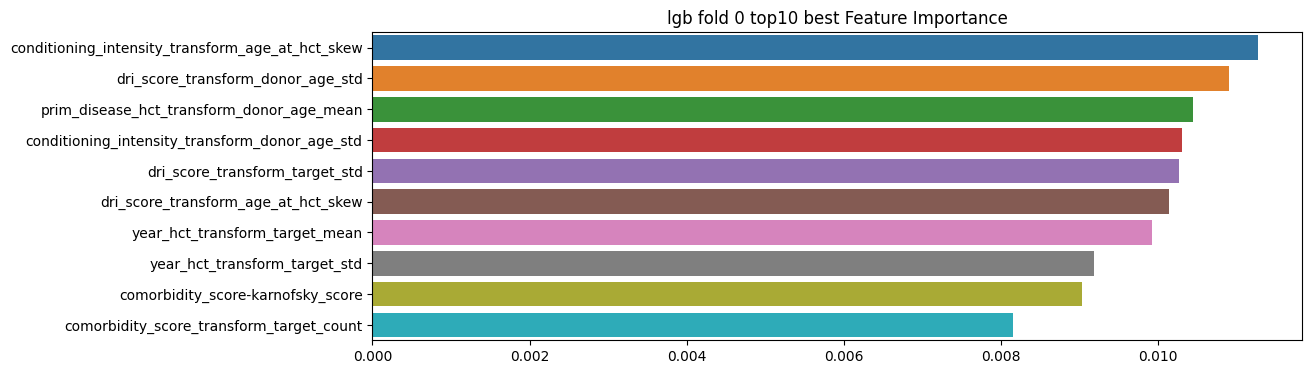

 10%|█         | 1/10 [02:08<19:19, 128.86s/it]

name:lgb,fold:1
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.183599
[500]	valid_0's l1: 0.182321
[750]	valid_0's l1: 0.181531
Did not meet early stopping. Best iteration is:
[767]	valid_0's l1: 0.18145
top10 best features is :['dri_score_transform_target_std', 'dri_score_transform_donor_age_std', 'prim_disease_hct_transform_donor_age_mean', 'conditioning_intensity_transform_target_skew', 'conditioning_intensity_transform_age_at_hct_skew', 'comorbidity_score/karnofsky_score', 'year_hct_transform_target_mean', 'dri_score_transform_age_at_hct_std', 'year_hct_transform_target_skew', 'conditioning_intensity_transform_age_at_hct_mean']
top10 worst features is :['rituximabin_vivo_tcd_transform_age_at_hct_count', 'graft_type_transform_target_count', 'vent_hist_transform_donor_age_count', 'vent_hist_transform_age_at_hct_count', 'hla_match_drb1_low_transform_target_count', 'prod_type_transform_donor_age_count', 'prod_type_transform_target_max', 'in_vivo_tc

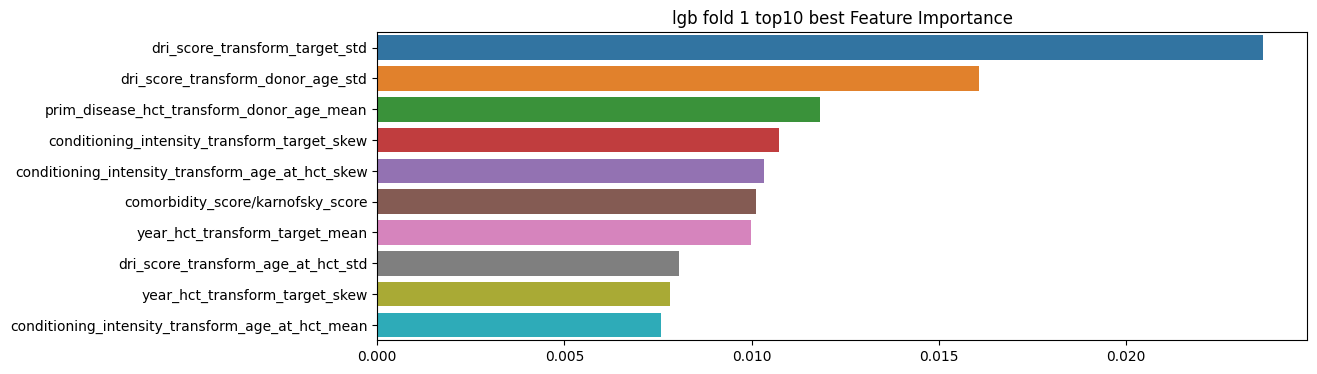

 20%|██        | 2/10 [04:01<15:56, 119.51s/it]

name:lgb,fold:2
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.185701
[500]	valid_0's l1: 0.184394
[750]	valid_0's l1: 0.183436
Did not meet early stopping. Best iteration is:
[766]	valid_0's l1: 0.183305
top10 best features is :['prim_disease_hct_transform_target_std', 'dri_score_transform_target_std', 'conditioning_intensity_transform_age_at_hct_skew', 'dri_score_transform_target_mean', 'year_hct_transform_target_std', 'prim_disease_hct_transform_target_mean', 'comorbidity_score/karnofsky_score', 'dri_score_transform_target_max', 'comorbidity_score-karnofsky_score', 'year_hct_transform_target_mean']
top10 worst features is :['rituximab_transform_age_at_hct_count', 'vent_histprod_type_transform_donor_age_count', 'graft_typevent_hist_transform_donor_age_count', 'vent_hist', 'graft_type_transform_age_at_hct_count', 'prod_type_transform_donor_age_count', 'in_vivo_tcd_transform_age_at_hct_count', 'in_vivo_tcd_transform_target_count', 'hla_match_a_low_

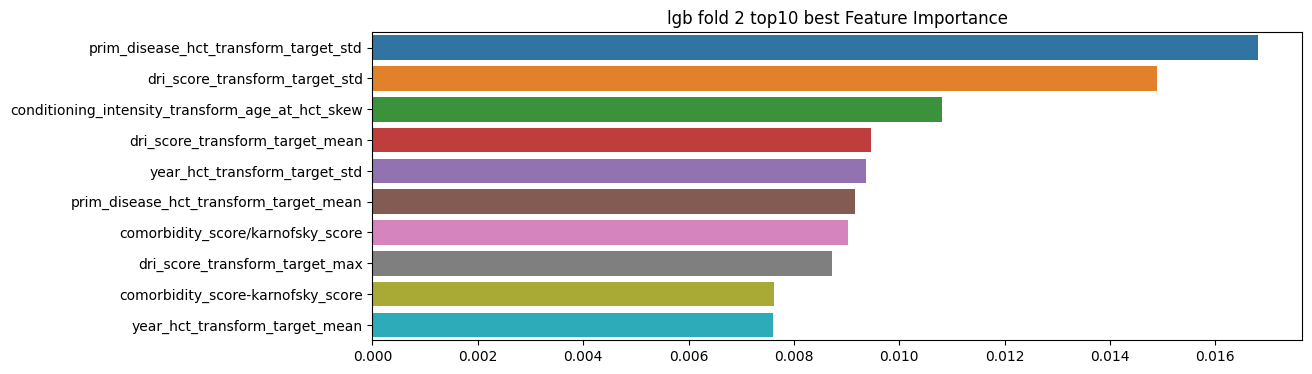

 30%|███       | 3/10 [05:55<13:36, 116.70s/it]

name:lgb,fold:3
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.183384
[500]	valid_0's l1: 0.182542
[750]	valid_0's l1: 0.181768
Did not meet early stopping. Best iteration is:
[768]	valid_0's l1: 0.181693
top10 best features is :['dri_score_transform_donor_age_std', 'comorbidity_score/karnofsky_score', 'dri_score_transform_target_std', 'prim_disease_hct_transform_target_mean', 'conditioning_intensity_transform_target_skew', 'conditioning_intensity_transform_donor_age_mean', 'dri_score_transform_target_mean', 'conditioning_intensity_transform_age_at_hct_mean', 'year_hct_transform_target_skew', 'year_hct_transform_target_mean']
top10 worst features is :['graft_type_transform_age_at_hct_count', 'graft_type_transform_target_count', 'vent_hist_transform_age_at_hct_count', 'prod_type_transform_donor_age_count', 'prod_type_transform_target_max', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_tcd_transform_target_count', 'graft_typevent_hist_transform_a

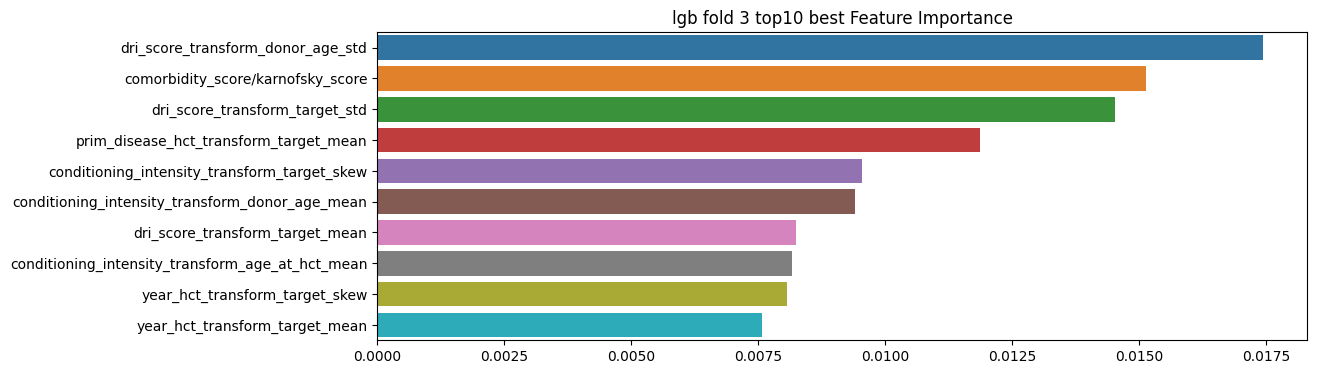

 40%|████      | 4/10 [07:49<11:34, 115.74s/it]

name:lgb,fold:4
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.186035
[500]	valid_0's l1: 0.185076
[750]	valid_0's l1: 0.184039
Did not meet early stopping. Best iteration is:
[768]	valid_0's l1: 0.183887
top10 best features is :['dri_score_transform_target_std', 'comorbidity_score/karnofsky_score', 'conditioning_intensity_transform_donor_age_std', 'conditioning_intensity_transform_age_at_hct_skew', 'year_hct_transform_target_mean', 'dri_score_transform_target_skew', 'comorbidity_score-karnofsky_score', 'conditioning_intensity_transform_age_at_hct_mean', 'dri_score_transform_target_mean', 'prim_disease_hct_transform_age_at_hct_skew']
top10 worst features is :['hla_match_c_low_transform_target_count', 'vent_hist_transform_age_at_hct_count', 'graft_type_transform_target_count', 'vent_hist', 'vent_hist_transform_target_count', 'prod_type_transform_age_at_hct_count', 'prod_type_transform_target_count', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_

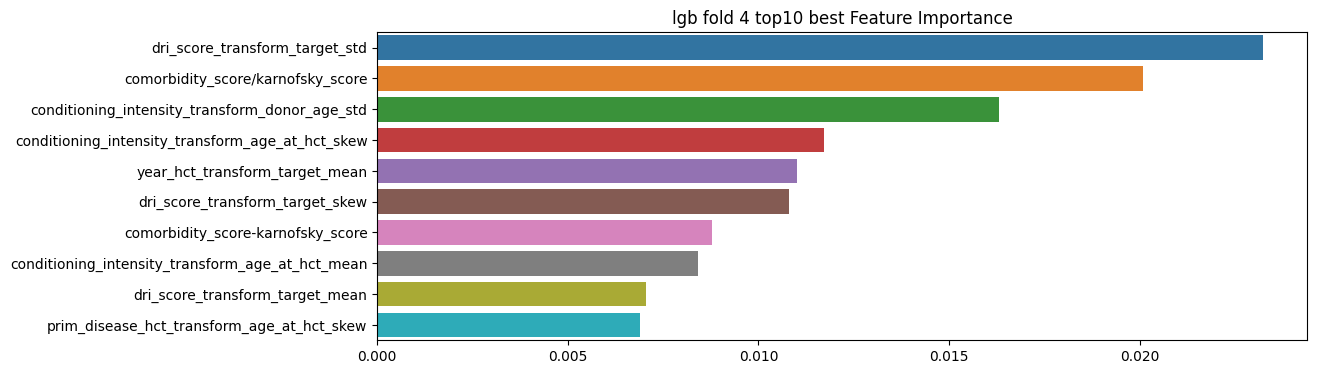

 50%|█████     | 5/10 [09:45<09:39, 115.82s/it]

name:lgb,fold:5
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.180417
[500]	valid_0's l1: 0.179171
[750]	valid_0's l1: 0.178465
Did not meet early stopping. Best iteration is:
[767]	valid_0's l1: 0.178393
top10 best features is :['dri_score_transform_target_std', 'prim_disease_hct_transform_age_at_hct_mean', 'conditioning_intensity_transform_target_mean', 'conditioning_intensity_transform_donor_age_max', 'conditioning_intensity_transform_donor_age_mean', 'dri_score_transform_donor_age_std', 'year_hct_transform_target_mean', 'conditioning_intensity_transform_target_max', 'dri_score_transform_target_max', 'comorbidity_score-karnofsky_score']
top10 worst features is :['graft_type_transform_age_at_hct_count', 'hla_match_c_low_transform_donor_age_count', 'rituximab_transform_age_at_hct_count', 'prod_type_transform_donor_age_count', 'prod_type_transform_target_count', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_tcd_transform_target_count', 'melphal

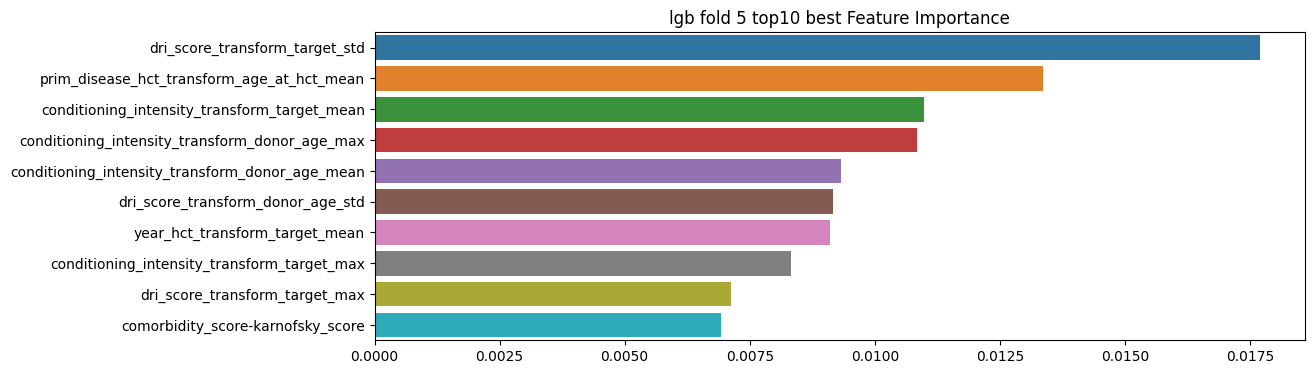

 60%|██████    | 6/10 [11:39<07:40, 115.17s/it]

name:lgb,fold:6
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.180719
[500]	valid_0's l1: 0.179065
[750]	valid_0's l1: 0.178221
Did not meet early stopping. Best iteration is:
[761]	valid_0's l1: 0.178145
top10 best features is :['dri_score_transform_target_std', 'conditioning_intensity_transform_donor_age_std', 'dri_score_transform_age_at_hct_mean', 'year_hct_transform_target_mean', 'prim_disease_hct_transform_target_std', 'prim_disease_hct_transform_target_skew', 'comorbidity_score-karnofsky_score', 'dri_score_transform_donor_age_max', 'dri_score_transform_donor_age_std', 'comorbidity_score_transform_age_at_hct_count']
top10 worst features is :['hla_match_drb1_low_transform_target_count', 'vent_histrituximab_transform_donor_age_count', 'vent_hist', 'vent_hist_transform_donor_age_count', 'vent_hist_transform_age_at_hct_count', 'hla_match_dqb1_high_transform_donor_age_count', 'prod_type_transform_age_at_hct_count', 'in_vivo_tcd_transform_age_at_hct

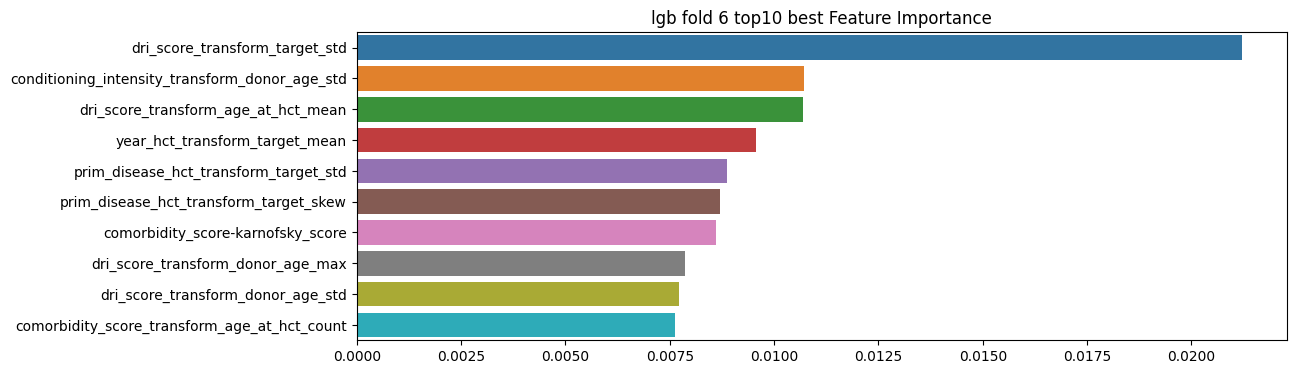

 70%|███████   | 7/10 [13:32<05:43, 114.59s/it]

name:lgb,fold:7
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.180896
[500]	valid_0's l1: 0.1797
[750]	valid_0's l1: 0.178903
Did not meet early stopping. Best iteration is:
[768]	valid_0's l1: 0.178825
top10 best features is :['conditioning_intensity_transform_donor_age_mean', 'dri_score_transform_target_skew', 'comorbidity_score/karnofsky_score', 'conditioning_intensity_transform_target_mean', 'dri_score_transform_target_mean', 'comorbidity_score-karnofsky_score', 'conditioning_intensity_transform_target_max', 'comorbidity_score_transform_age_at_hct_skew', 'dri_score_transform_donor_age_std', 'dri_score_transform_donor_age_max']
top10 worst features is :['vent_histprod_type_transform_target_count', 'hla_match_a_low_transform_donor_age_count', 'graft_type_transform_target_count', 'vent_hist_transform_target_count', 'hla_match_drb1_low_transform_donor_age_count', 'prod_type_transform_age_at_hct_count', 'prod_type_transform_target_count', 'in_vivo_t

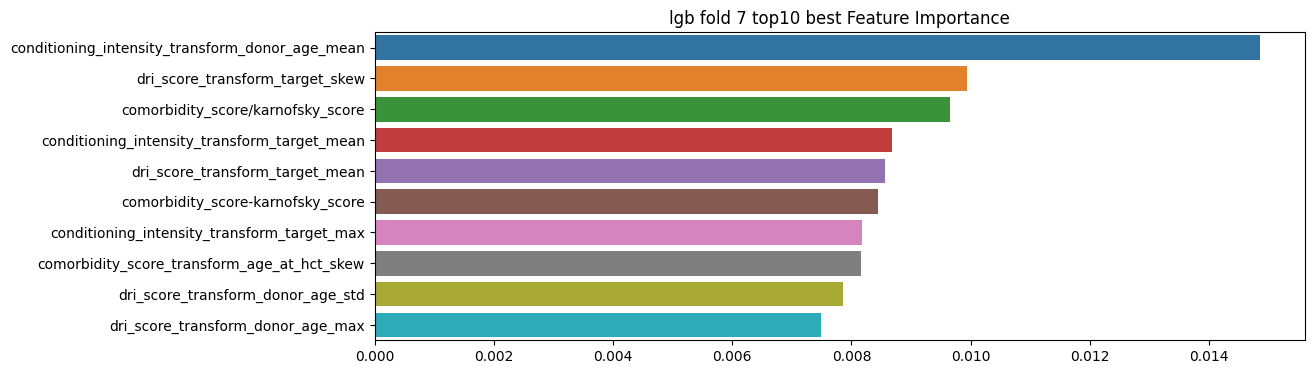

 80%|████████  | 8/10 [15:26<03:48, 114.38s/it]

name:lgb,fold:8
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.183106
[500]	valid_0's l1: 0.182503
[750]	valid_0's l1: 0.182232
Did not meet early stopping. Best iteration is:
[735]	valid_0's l1: 0.182175
top10 best features is :['dri_score_transform_target_std', 'conditioning_intensity_transform_age_at_hct_skew', 'prim_disease_hct_transform_donor_age_mean', 'conditioning_intensity_transform_target_skew', 'year_hct_transform_target_std', 'dri_score_transform_donor_age_std', 'comorbidity_score/karnofsky_score', 'conditioning_intensity_transform_donor_age_std', 'comorbidity_score-karnofsky_score', 'donor_age']
top10 worst features is :['in_vivo_tcd_transform_target_count', 'prod_type_transform_donor_age_count', 'vent_hist', 'vent_hist_transform_donor_age_count', 'rituximab_transform_donor_age_count', 'in_vivo_tcd_transform_donor_age_count', 'in_vivo_tcd_transform_age_at_hct_count', 'graft_typevent_hist_transform_donor_age_count', 'graft_typevent_hist

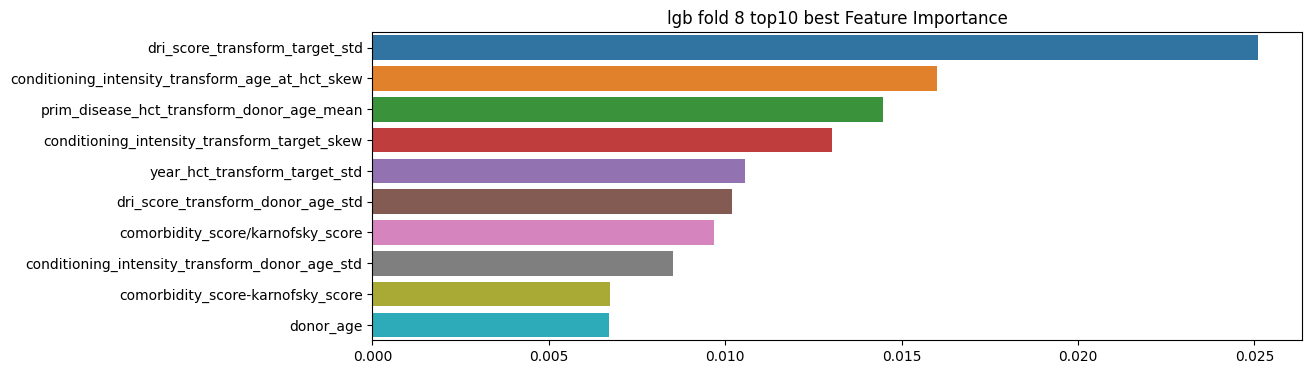

 90%|█████████ | 9/10 [17:21<01:54, 114.40s/it]

name:lgb,fold:9
Training until validation scores don't improve for 1000 rounds
[250]	valid_0's l1: 0.185683
[500]	valid_0's l1: 0.184534
[750]	valid_0's l1: 0.184255
Did not meet early stopping. Best iteration is:
[764]	valid_0's l1: 0.184167
top10 best features is :['dri_score_transform_target_std', 'dri_score_transform_donor_age_std', 'conditioning_intensity_transform_donor_age_std', 'conditioning_intensity_transform_target_skew', 'comorbidity_score_transform_target_count', 'comorbidity_score/karnofsky_score', 'conditioning_intensity_transform_donor_age_mean', 'cyto_score_detail_transform_target_std', 'year_hct_transform_target_mean', 'conditioning_intensity_transform_donor_age_max']
top10 worst features is :['melphalan_dose_transform_target_count', 'hla_match_b_low_transform_target_count', 'melphalan_dose_transform_donor_age_count', 'vent_hist_transform_donor_age_count', 'prod_type', 'rituximab_transform_age_at_hct_count', 'prod_type_transform_donor_age_count', 'in_vivo_tcd_transfor

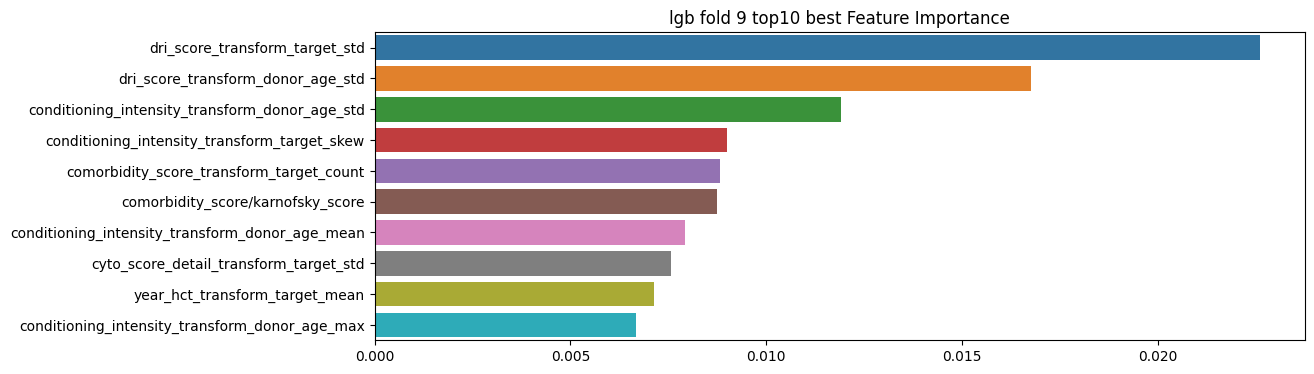

100%|██████████| 10/10 [19:15<00:00, 115.56s/it]


mae------------------------------>0.18155634579394878


  0%|          | 0/10 [00:00<?, ?it/s]

name:cat,fold:0


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2005724	test: 0.2186184	best: 0.2186184 (0)	total: 5.01s	remaining: 54m 14s
250:	learn: 0.1321625	test: 0.1853652	best: 0.1853652 (250)	total: 12.3s	remaining: 19.5s
500:	learn: 0.1060608	test: 0.1832052	best: 0.1832052 (500)	total: 19.4s	remaining: 5.77s
649:	learn: 0.0943014	test: 0.1824392	best: 0.1824392 (649)	total: 23.7s	remaining: 0us
bestTest = 0.1824392107
bestIteration = 649
top10 best features is :['donor_age', 'age_at_hct', 'dri_score_transform_target_std', 'comorbidity_score/karnofsky_score', 'comorbidity_score-karnofsky_score', 'donor_age*age_at_hct', 'donor_age_divide_age_at_hct', 'donor_age-age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age+age_at_hct']
top10 worst features is :['prod_typemelphalan_dose_transform_donor_age_std', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_mean', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_target_count', 'mrd_hctin_vivo_

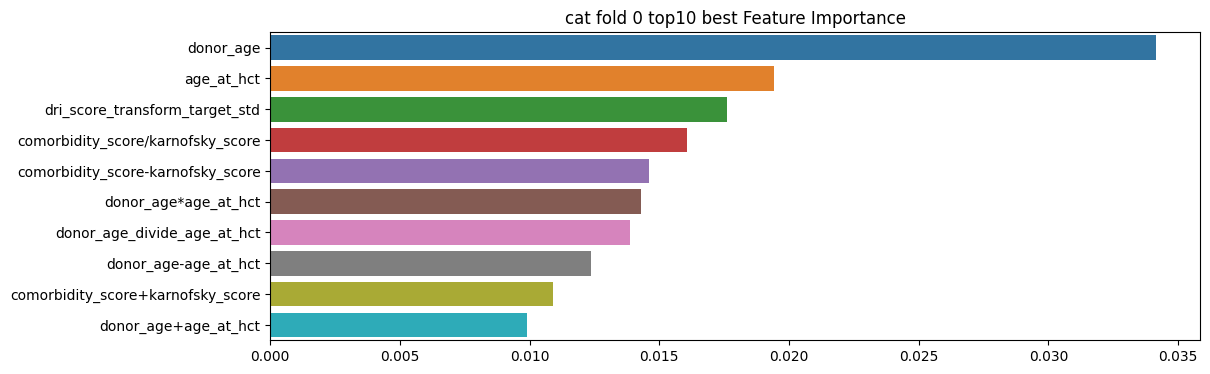

 10%|█         | 1/10 [01:46<15:55, 106.17s/it]

name:cat,fold:1


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2004686	test: 0.2195077	best: 0.2195077 (0)	total: 31.6ms	remaining: 20.5s
250:	learn: 0.1333476	test: 0.1828183	best: 0.1828183 (250)	total: 7.17s	remaining: 11.4s
500:	learn: 0.1070241	test: 0.1805069	best: 0.1804979 (492)	total: 14.3s	remaining: 4.26s
649:	learn: 0.0949435	test: 0.1798880	best: 0.1797738 (619)	total: 18.6s	remaining: 0us
bestTest = 0.1797738181
bestIteration = 619
Shrink model to first 620 iterations.
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'donor_age-age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age_divide_age_at_hct', 'donor_age+age_at_hct', 'comorbidity_score-karnofsky_score', 'comorbidity_score+karnofsky_score', 'donor_age*age_at_hct']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_max', 'prod_typemelphalan_dose_transform_age_at_hct_mean', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_target_mean', 'prod_typemelphalan_dose_transform_tar

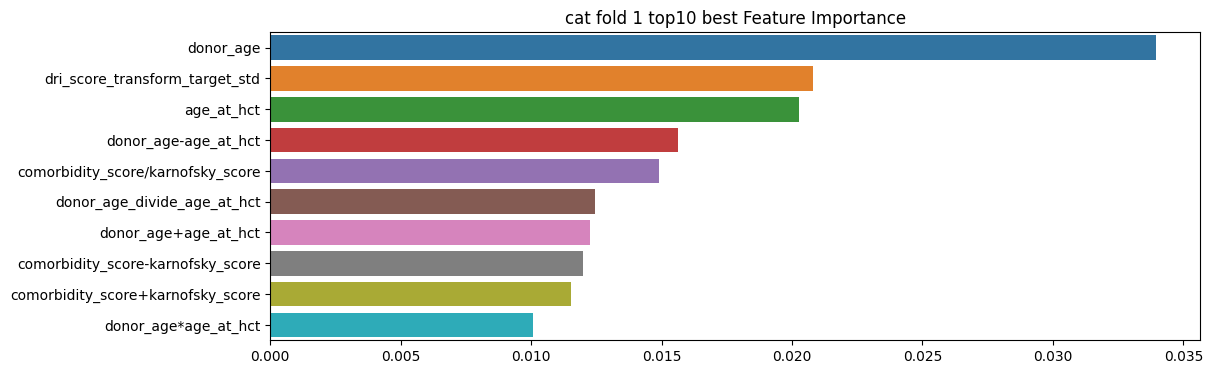

 20%|██        | 2/10 [03:06<12:07, 90.90s/it] 

name:cat,fold:2


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2002554	test: 0.2213291	best: 0.2213291 (0)	total: 34.8ms	remaining: 22.6s
250:	learn: 0.1330454	test: 0.1853895	best: 0.1853895 (250)	total: 7.13s	remaining: 11.3s
500:	learn: 0.1066720	test: 0.1826012	best: 0.1826012 (500)	total: 14.3s	remaining: 4.24s
649:	learn: 0.0942974	test: 0.1812290	best: 0.1812276 (648)	total: 18.5s	remaining: 0us
bestTest = 0.1812275781
bestIteration = 648
Shrink model to first 649 iterations.
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'donor_age-age_at_hct', 'comorbidity_score-karnofsky_score', 'comorbidity_score/karnofsky_score', 'donor_age_divide_age_at_hct', 'donor_age*age_at_hct', 'year_hct_transform_target_std', 'donor_age+age_at_hct']
top10 worst features is :['prod_typein_vivo_tcd_transform_donor_age_std', 'prod_typein_vivo_tcd_transform_donor_age_skew', 'prod_typein_vivo_tcd_transform_age_at_hct_mean', 'prod_typein_vivo_tcd_transform_age_at_hct_std', 'prod_typein_vivo_tcd_transform_target_count'

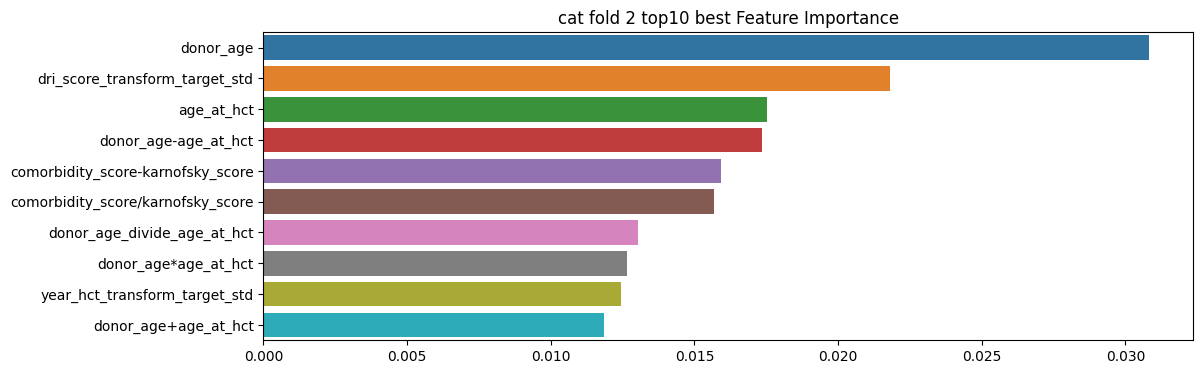

 30%|███       | 3/10 [04:26<10:01, 85.96s/it]

name:cat,fold:3


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2005764	test: 0.2187900	best: 0.2187900 (0)	total: 32.6ms	remaining: 21.2s
250:	learn: 0.1331492	test: 0.1843952	best: 0.1843852 (248)	total: 7.18s	remaining: 11.4s
500:	learn: 0.1066917	test: 0.1814374	best: 0.1814374 (500)	total: 14.3s	remaining: 4.24s
649:	learn: 0.0952478	test: 0.1808658	best: 0.1808647 (646)	total: 18.6s	remaining: 0us
bestTest = 0.1808647156
bestIteration = 646
Shrink model to first 647 iterations.
top10 best features is :['donor_age', 'age_at_hct', 'dri_score_transform_target_std', 'donor_age-age_at_hct', 'comorbidity_score/karnofsky_score', 'comorbidity_score-karnofsky_score', 'donor_age_divide_age_at_hct', 'donor_age*age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age+age_at_hct']
top10 worst features is :['prod_typemelphalan_dose_transform_donor_age_mean', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_age_at_hct_skew', 'prod_typemelphalan_dose_transform_target_count', 'prod_typemelphalan_dose_trans

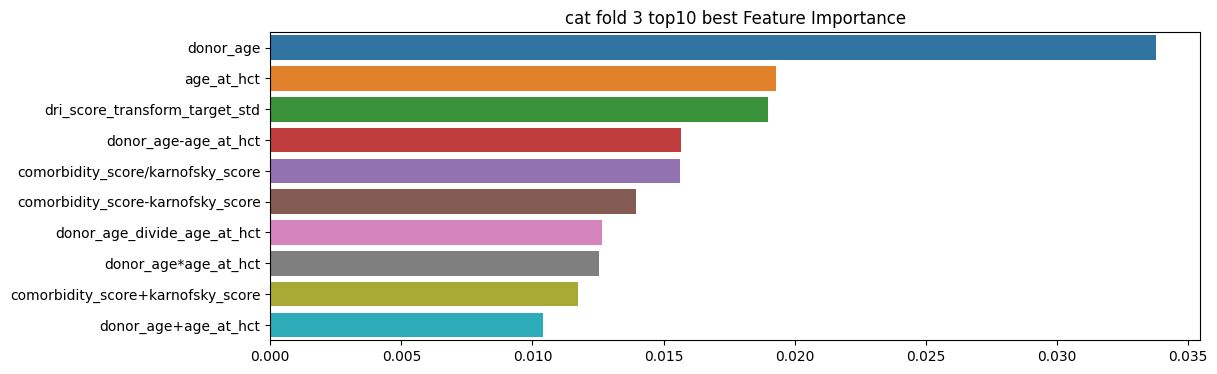

 40%|████      | 4/10 [05:47<08:23, 83.88s/it]

name:cat,fold:4


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2000469	test: 0.2228436	best: 0.2228436 (0)	total: 32.3ms	remaining: 21s
250:	learn: 0.1330537	test: 0.1865308	best: 0.1865308 (250)	total: 7.16s	remaining: 11.4s
500:	learn: 0.1064913	test: 0.1848012	best: 0.1847808 (495)	total: 14.3s	remaining: 4.25s
649:	learn: 0.0942931	test: 0.1842340	best: 0.1842340 (649)	total: 18.6s	remaining: 0us
bestTest = 0.1842340257
bestIteration = 649
top10 best features is :['donor_age', 'age_at_hct', 'dri_score_transform_target_std', 'comorbidity_score/karnofsky_score', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'donor_age-age_at_hct', 'donor_age*age_at_hct', 'donor_age+age_at_hct', 'comorbidity_score+karnofsky_score']
top10 worst features is :['prod_typemelphalan_dose_transform_target_count', 'prod_typemelphalan_dose_transform_target_mean', 'prod_typemelphalan_dose_transform_target_skew', 'mrd_hctin_vivo_tcd_transform_donor_age_max', 'mrd_hctin_vivo_tcd_transform_age_at_hct_count', 'in_vivo_tcdmelphalan_dose_transfo

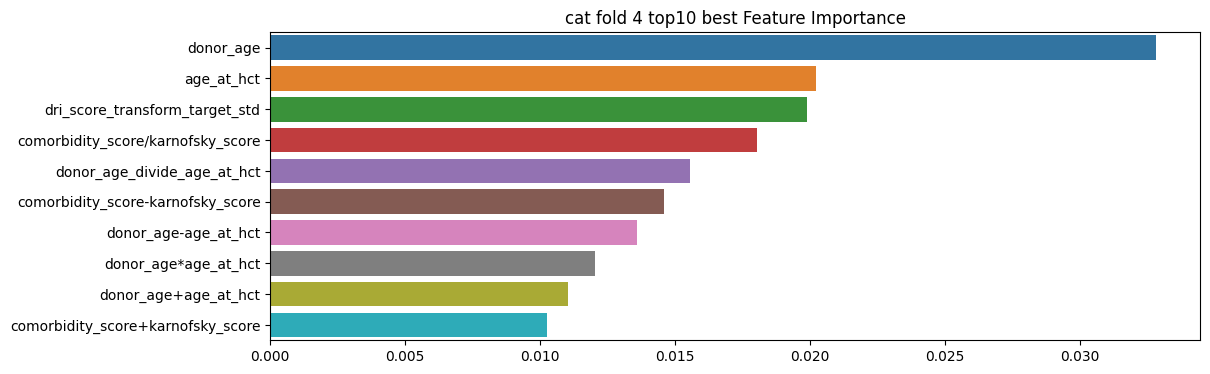

 50%|█████     | 5/10 [07:07<06:53, 82.68s/it]

name:cat,fold:5


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2010388	test: 0.2169667	best: 0.2169667 (0)	total: 30.8ms	remaining: 20s
250:	learn: 0.1334395	test: 0.1804952	best: 0.1804952 (250)	total: 7.12s	remaining: 11.3s
500:	learn: 0.1072327	test: 0.1785876	best: 0.1785669 (498)	total: 14.4s	remaining: 4.28s
649:	learn: 0.0949070	test: 0.1772220	best: 0.1771667 (643)	total: 18.6s	remaining: 0us
bestTest = 0.1771667269
bestIteration = 643
Shrink model to first 644 iterations.
top10 best features is :['donor_age', 'age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age-age_at_hct', 'donor_age_divide_age_at_hct', 'dri_score_transform_target_std', 'comorbidity_score-karnofsky_score', 'donor_age+age_at_hct', 'comorbidity_score+karnofsky_score', 'dri_score_transform_donor_age_std']
top10 worst features is :['prod_typemelphalan_dose_transform_donor_age_max', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_target_count', 'prod_typemelphalan_dose_transform_target_mean', 'prod_typemelphalan_dose

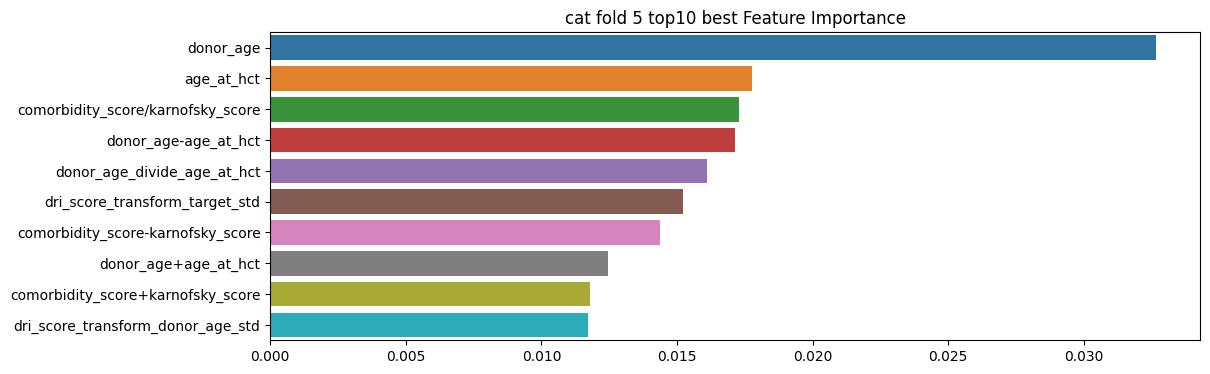

 60%|██████    | 6/10 [08:28<05:28, 82.06s/it]

name:cat,fold:6


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2002267	test: 0.2215818	best: 0.2215818 (0)	total: 32.4ms	remaining: 21.1s
250:	learn: 0.1334466	test: 0.1816322	best: 0.1815996 (249)	total: 7.17s	remaining: 11.4s
500:	learn: 0.1064893	test: 0.1789021	best: 0.1788620 (495)	total: 14.3s	remaining: 4.25s
649:	learn: 0.0945975	test: 0.1779298	best: 0.1779244 (648)	total: 18.6s	remaining: 0us
bestTest = 0.1779244317
bestIteration = 648
Shrink model to first 649 iterations.
top10 best features is :['donor_age', 'dri_score_transform_target_std', 'age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age-age_at_hct', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'donor_age*age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age+age_at_hct']
top10 worst features is :['prod_typein_vivo_tcd_transform_age_at_hct_count', 'prod_typein_vivo_tcd_transform_age_at_hct_mean', 'prod_typein_vivo_tcd_transform_age_at_hct_std', 'prod_typein_vivo_tcd_transform_age_at_hct_skew', 'prod_typemelphalan_dose_transform_do

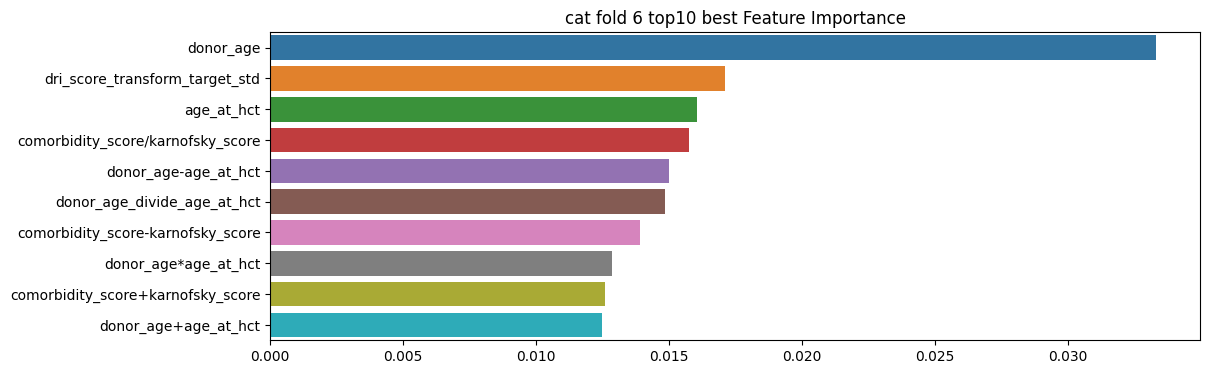

 70%|███████   | 7/10 [09:49<04:05, 81.77s/it]

name:cat,fold:7


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2006986	test: 0.2191506	best: 0.2191506 (0)	total: 32ms	remaining: 20.8s
250:	learn: 0.1330358	test: 0.1825055	best: 0.1825055 (250)	total: 7.23s	remaining: 11.5s
500:	learn: 0.1065821	test: 0.1798818	best: 0.1798475 (499)	total: 14.5s	remaining: 4.31s
649:	learn: 0.0942823	test: 0.1793723	best: 0.1793274 (646)	total: 18.8s	remaining: 0us
bestTest = 0.1793273926
bestIteration = 646
Shrink model to first 647 iterations.
top10 best features is :['donor_age', 'age_at_hct', 'donor_age_divide_age_at_hct', 'dri_score_transform_target_std', 'comorbidity_score/karnofsky_score', 'donor_age-age_at_hct', 'donor_age+age_at_hct', 'comorbidity_score-karnofsky_score', 'dri_score_transform_donor_age_std', 'donor_age*age_at_hct']
top10 worst features is :['prod_typemelphalan_dose_transform_donor_age_max', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_age_at_hct_mean', 'prod_typemelphalan_dose_tran

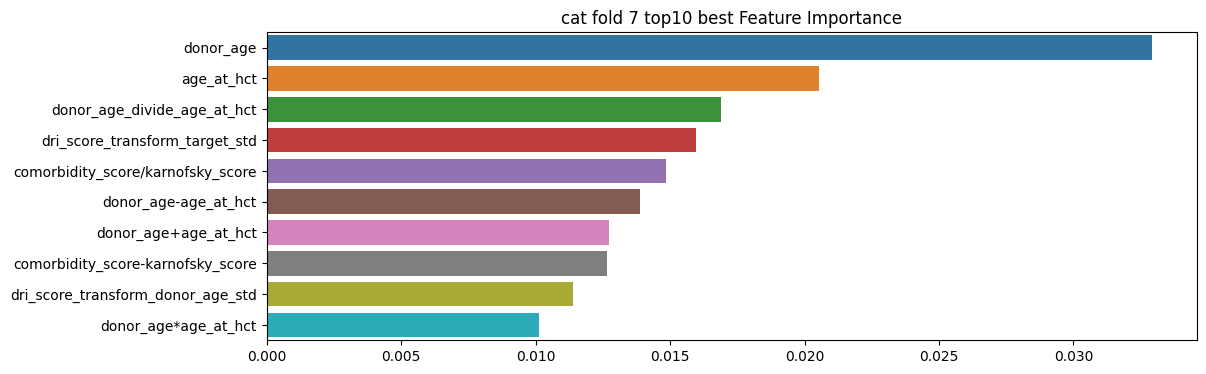

 80%|████████  | 8/10 [11:10<02:42, 81.39s/it]

name:cat,fold:8


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.2004649	test: 0.2186805	best: 0.2186805 (0)	total: 32.4ms	remaining: 21s
250:	learn: 0.1335108	test: 0.1848142	best: 0.1848142 (250)	total: 7.17s	remaining: 11.4s
500:	learn: 0.1071488	test: 0.1827952	best: 0.1827349 (418)	total: 14.3s	remaining: 4.25s
649:	learn: 0.0948304	test: 0.1822147	best: 0.1821992 (640)	total: 18.6s	remaining: 0us
bestTest = 0.1821992026
bestIteration = 640
Shrink model to first 641 iterations.
top10 best features is :['donor_age', 'age_at_hct', 'dri_score_transform_target_std', 'donor_age-age_at_hct', 'donor_age_divide_age_at_hct', 'comorbidity_score-karnofsky_score', 'comorbidity_score/karnofsky_score', 'donor_age*age_at_hct', 'donor_age+age_at_hct', 'year_hct_transform_target_std']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_mean', 'prod_typemelphalan_dose_transform_donor_age_max', 'prod_typemelphalan_dose_transform_donor_age_skew', 'prod_typemelphalan_dose_transform_age_at_hct_count', 'prod_typemelphalan_dose_transform_targe

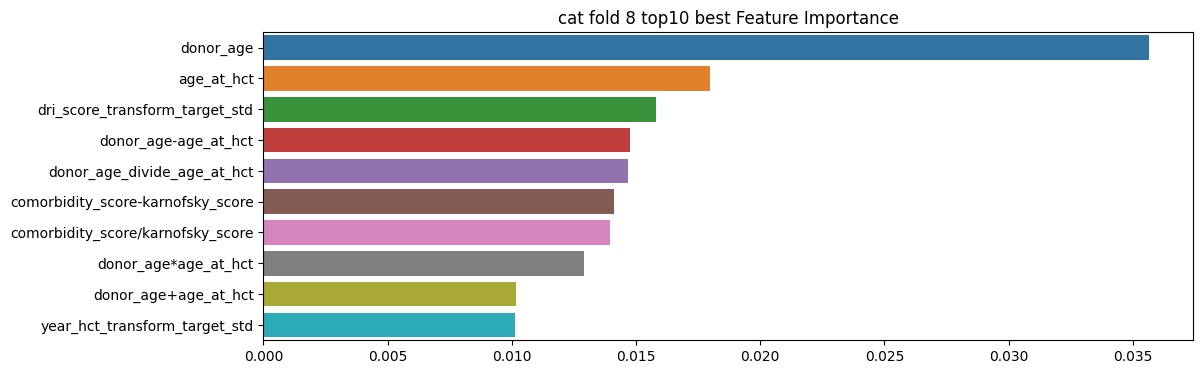

 90%|█████████ | 9/10 [12:30<01:20, 80.95s/it]

name:cat,fold:9


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.1999389	test: 0.2236215	best: 0.2236215 (0)	total: 31.4ms	remaining: 20.4s
250:	learn: 0.1334050	test: 0.1860114	best: 0.1860114 (250)	total: 7.21s	remaining: 11.5s
500:	learn: 0.1063898	test: 0.1834390	best: 0.1834390 (500)	total: 14.3s	remaining: 4.27s
649:	learn: 0.0944300	test: 0.1826953	best: 0.1826376 (634)	total: 18.6s	remaining: 0us
bestTest = 0.1826375749
bestIteration = 634
Shrink model to first 635 iterations.
top10 best features is :['donor_age', 'age_at_hct', 'comorbidity_score/karnofsky_score', 'donor_age-age_at_hct', 'comorbidity_score-karnofsky_score', 'donor_age_divide_age_at_hct', 'dri_score_transform_target_std', 'donor_age*age_at_hct', 'comorbidity_score+karnofsky_score', 'donor_age+age_at_hct']
top10 worst features is :['prod_typein_vivo_tcd_transform_target_skew', 'prod_typemelphalan_dose_transform_age_at_hct_max', 'prod_typemelphalan_dose_transform_target_max', 'prod_typemelphalan_dose_transform_target_skew', 'mrd_hctin_vivo_tcd_transform_donor_age_ma

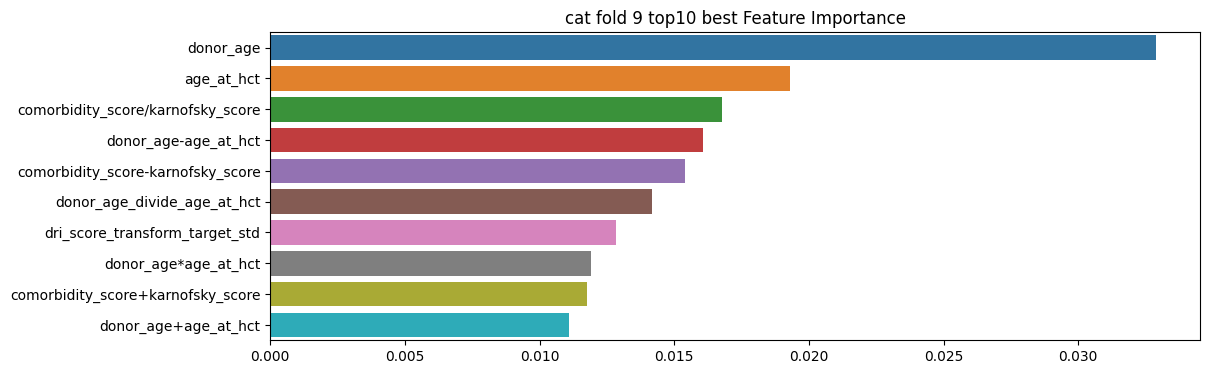

100%|██████████| 10/10 [13:50<00:00, 83.04s/it]

mae------------------------------>0.18077947220927082


In [13]:
#nunique=2
nunique2=[col for col in train.columns if train[col].nunique()==2 and col!='efs']
#nunique<50
nunique50=[col for col in train.columns if train[col].nunique()<50 and col not in ['efs','weight']]+['age_group','dri_score_NA']

def FE(df):
    print("< deal with outlier >")
    df['nan_value_each_row'] = df.isnull().sum(axis=1)
    #year_hct=2020 only 4 rows.
    df['year_hct']=df['year_hct'].replace(2020,2019)
    df['age_group']=df['age_at_hct']//10
    #karnofsky_score 40 only 10 rows.
    df['karnofsky_score']=df['karnofsky_score'].replace(40,50)
    #hla_high_res_8=2 only 2 rows.
    df['hla_high_res_8']=df['hla_high_res_8'].replace(2,3)
    #hla_high_res_6=0 only 1 row.
    df['hla_high_res_6']=df['hla_high_res_6'].replace(0,2)
    #hla_high_res_10=3 only 1 row.
    df['hla_high_res_10']=df['hla_high_res_10'].replace(3,4)
    #hla_low_res_8=2 only 1 row.
    df['hla_low_res_8']=df['hla_low_res_8'].replace(2,3)
    df['dri_score']=df['dri_score'].replace('Missing disease status','N/A - disease not classifiable')
    df['dri_score_NA']=df['dri_score'].apply(lambda x:int('N/A' in str(x)))
    for col in ['diabetes','pulm_moderate','cardiac']:
        df.loc[df[col].isna(),col]='Not done'

    print("< cross feature >")
    df['donor_age-age_at_hct']=df['donor_age']-df['age_at_hct']
    df['comorbidity_score+karnofsky_score']=df['comorbidity_score']+df['karnofsky_score']
    df['comorbidity_score-karnofsky_score']=df['comorbidity_score']-df['karnofsky_score']
    df['comorbidity_score*karnofsky_score']=df['comorbidity_score']*df['karnofsky_score']
    df['comorbidity_score/karnofsky_score']=df['comorbidity_score']/df['karnofsky_score']
    
    print("< fillna >")
    df[nunique50]=df[nunique50].astype(str).fillna('NaN')
    
    print("< combine category feature >")
    for i in range(len(nunique2)):
        for j in range(i+1,len(nunique2)):
            df[nunique2[i]+nunique2[j]]=df[nunique2[i]].astype(str)+df[nunique2[j]].astype(str)
    
    print("< drop useless columns >")
    df.drop(['ID'],axis=1,inplace=True,errors='ignore')
    return df

combine_category_cols=[]
for i in range(len(nunique2)):
    for j in range(i+1,len(nunique2)):
        combine_category_cols.append(nunique2[i]+nunique2[j])  

total_category_feature=nunique50+combine_category_cols

target_stat=[]
for j in range(len(total_category_feature)):
   for col in ['donor_age','age_at_hct','target']:
    target_stat.append( (total_category_feature[j],col,['count','mean','max','std','skew']) )

num_folds=10

lgb_params={"boosting_type": "gbdt","metric": 'mae',
            'random_state': 2025,  "max_depth": 9,"learning_rate": 0.1,
            "n_estimators": 768,"colsample_bytree": 0.6,"colsample_bynode": 0.6,
            "verbose": -1,"reg_alpha": 0.2,
            "reg_lambda": 5,"extra_trees":True,'num_leaves':64,"max_bin":255,
            'importance_type': 'gain',#better than 'split'
            'device':'gpu','gpu_use_dp':True
           }

cat_params={'random_state':2025,'eval_metric' : 'MAE',
            'bagging_temperature': 0.50,'iterations': 650,
            'learning_rate': 0.1,'max_depth': 8,
            'l2_leaf_reg': 1.25,'min_data_in_leaf': 24,
            'random_strength' : 0.25, 'verbose': 0,
            'task_type':'GPU',
            }
# xgb_params={'random_state': 2025, 'n_estimators': 256, 
#             'learning_rate': 0.1, 'max_depth': 6,
#             'reg_alpha': 0.08, 'reg_lambda': 0.8, 
#             'subsample': 0.95, 'colsample_bytree': 0.6, 
#             'min_child_weight': 3,'early_stopping_rounds':1024,
#              'enable_categorical':True,'tree_method':'gpu_hist'
#             }

yunbase=Yunbase(num_folds=num_folds,
                  models=[(LGBMRegressor(**lgb_params),'lgb'),
                          (CatBoostRegressor(**cat_params),'cat'),
                          # (XGBRegressor(**xgb_params),'xgb')
                         ],
                  FE=FE,
                  seed=2025,
                  objective='regression',
                  metric='mae',
                  target_col='target',
                  device='gpu',
                  one_hot_max=-1,
                  early_stop=1000,
                  cross_cols=['donor_age','age_at_hct'],
                  target_stat=target_stat,
                  use_data_augmentation=True,
                  use_scaler=True,
                  log=250,
                  plot_feature_importance=True,
                  #print metric score when model training
                  use_eval_metric=False,
)
yunbase.fit(train,category_cols=nunique2)

In [14]:
import pandas.api.types
from lifelines.utils import concordance_index

class ParticipantVisibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
        if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

weights = [0.5,0.5]

lgb_prediction=np.load(f"Yunbase_info/lgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}_{yunbase.target_col}.npy")
lgb_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':lgb_prediction})
print(f"lgb_score:{score(train_solution.copy(),lgb_prediction.copy(),row_id_column_name='ID')}")
# xgb_prediction=np.load(f"Yunbase_info/xgb_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}_{yunbase.target_col}.npy")
# xgb_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':xgb_prediction})
# print(f"xgb_score:{score(train_solution.copy(),xgb_prediction.copy(),row_id_column_name='ID')}")
cat_prediction=np.load(f"Yunbase_info/cat_seed{yunbase.seed}_repeat0_fold{yunbase.num_folds}_{yunbase.target_col}.npy")
cat_prediction=pd.DataFrame({'ID':train_solution['ID'],'prediction':cat_prediction})
print(f"cat_score:{score(train_solution.copy(),cat_prediction.copy(),row_id_column_name='ID')}")

y_preds=[
    lgb_prediction.copy(),
    # xgb_prediction.copy(),
    cat_prediction.copy()
]

final_prediction=lgb_prediction.copy()
final_prediction['prediction']=0
for i in range(len(y_preds)):
    final_prediction['prediction']+=weights[i]*y_preds[i]['prediction']
metric=score(train_solution.copy(),final_prediction.copy(),row_id_column_name='ID')
print(f"final_CV:{metric}")

lgb_score:0.674488816963877
cat_score:0.6711143253357195
final_CV:0.6774178866790215


In [15]:
test_preds=yunbase.predict(test,weights=weights)
yunbase.target_col='prediction'
yunbase.submit("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv",test_preds,
               save_name='submission1'
              )

predict......
weight normalization
final_repeat0_mae:0.18033705131577452
load test data
Feature Engineer
< deal with outlier >
< cross feature >
< fillna >
< combine category feature >
< drop useless columns >


0it [00:00, ?it/s]

-> for column graft_type labelencoder feature
-> for column vent_hist labelencoder feature
-> for column rituximab labelencoder feature
-> for column hla_match_drb1_low labelencoder feature
-> for column prod_type labelencoder feature
-> for column mrd_hct labelencoder feature
-> for column in_vivo_tcd labelencoder feature
-> for column melphalan_dose labelencoder feature
< cross feature >
< drop useless cols >
nan_cols:[]
unique_cols:[]
drop_cols:[]
high_corr_cols:[]
< robust scaler >
------------------------------
test.shape:(3, 96)
prediction on test data


submission......


# **CIBMTR | EDA & Ensemble Model**

https://www.kaggle.com/code/andreasbis/cibmtr-eda-ensemble-model

In [16]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
autograd is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=e4c7bd72ce29251ff1ecb21b2982f392904baa3a5ddad0d4ed48bf3a9d5ed17c
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
  Attempting uninstall: autograd-gamma
    Found existing installation: autograd-gamma 0.5.0
    Uninstalling autograd-gamma-0.5.0:
      Successfully uninstalled autograd-gamma-0.5.0
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
interface-meta is already installed with the same version as the provided wheel. Use --force-r

In [17]:
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import numpy as np
import polars as pl
import pandas as pd
import plotly.colors as pc
import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = 'iframe'

pd.options.display.max_columns = None

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
import lightgbm as lgb
from metric import score
from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

In [18]:
class CFG:

    train_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
    test_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
    subm_path = Path('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
    
    colorscale = 'Redor'
    color = '#A2574F'

    batch_size = 32768
    early_stop = 300
    penalizer = 0.01
    n_splits = 5

    weights = [2, 1, 6, 3, 6, 3, 6, 6]

    ctb_params = {
        'loss_function': 'RMSE',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'depth': 8
    }

    lgb_params = {
        'objective': 'regression',
        'min_child_samples': 32,
        'num_iterations': 6000,
        'learning_rate': 0.03,
        'extra_trees': True,
        'reg_lambda': 8.0,
        'reg_alpha': 0.1,
        'num_leaves': 64,
        'metric': 'rmse',
        'max_depth': 8,
        'device': 'cpu',
        'max_bin': 128,
        'verbose': -1,
        'seed': 42
    }

    cox1_params = {
        'grow_policy': 'Depthwise',
        'min_child_samples': 8,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'depth': 8
    }

    cox2_params = {
        'grow_policy': 'Lossguide',
        'min_child_samples': 2,
        'loss_function': 'Cox',
        'learning_rate': 0.03,
        'random_state': 42,
        'task_type': 'CPU',
        'num_trees': 6000,
        'reg_lambda': 8.0,
        'num_leaves': 32,
        'depth': 8
    }

In [19]:
class FE:

    def __init__(self, batch_size):
        self._batch_size = batch_size

    def _load_data(self, path):

        return pl.read_csv(path, batch_size=self._batch_size)

    def _update_hla_columns(self, df):
        
        df = df.with_columns(
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_nmdp_6'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .alias('hla_low_res_6'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_high_res_6'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_c_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .alias('hla_low_res_8'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_c_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .alias('hla_high_res_8'),
            
            pl.col('hla_match_a_low').fill_null(0)
            .add(pl.col('hla_match_b_low').fill_null(0))
            .add(pl.col('hla_match_c_low').fill_null(0))
            .add(pl.col('hla_match_drb1_low').fill_null(0))
            .add(pl.col('hla_match_dqb1_low').fill_null(0))
            .alias('hla_low_res_10'),
            
            pl.col('hla_match_a_high').fill_null(0)
            .add(pl.col('hla_match_b_high').fill_null(0))
            .add(pl.col('hla_match_c_high').fill_null(0))
            .add(pl.col('hla_match_drb1_high').fill_null(0))
            .add(pl.col('hla_match_dqb1_high').fill_null(0))
            .alias('hla_high_res_10'),
            
        )
    
        return df

    def _cast_datatypes(self, df):

        num_cols = [
            'hla_high_res_8',
            'hla_low_res_8',
            'hla_high_res_6',
            'hla_low_res_6',
            'hla_high_res_10',
            'hla_low_res_10',
            'hla_match_dqb1_high',
            'hla_match_dqb1_low',
            'hla_match_drb1_high',
            'hla_match_drb1_low',
            'hla_nmdp_6',
            'year_hct',
            'hla_match_a_high',
            'hla_match_a_low',
            'hla_match_b_high',
            'hla_match_b_low',
            'hla_match_c_high',
            'hla_match_c_low',
            'donor_age',
            'age_at_hct',
            'comorbidity_score',
            'karnofsky_score',
            'efs',
            'efs_time'
        ]

        for col in df.columns:

            if col in num_cols:
                df = df.with_columns(pl.col(col).fill_null(-1).cast(pl.Float32))  

            else:
                df = df.with_columns(pl.col(col).fill_null('Unknown').cast(pl.String))  

        return df.with_columns(pl.col('ID').cast(pl.Int32))

    def info(self, df):
        
        print(f'\nShape of dataframe: {df.shape}') 
        
        mem = df.memory_usage().sum() / 1024**2
        print('Memory usage: {:.2f} MB\n'.format(mem))

        display(df.head())

    def apply_fe(self, path):

        df = self._load_data(path)   
        df = self._update_hla_columns(df)                     
        df = self._cast_datatypes(df)        
        df = df.to_pandas()
        self.info(df)
        
        cat_cols = [col for col in df.columns if df[col].dtype == pl.String]

        return df, cat_cols

fe = FE(CFG.batch_size)
train_data, cat_cols = fe.apply_fe(CFG.train_path)


Shape of dataframe: (28800, 60)
Memory usage: 10.44 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.355999
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672000
2,2,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.792999
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.348999
4,4,High,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,PB,Unknown,MAC,Hispanic or Latino,2018.0,No,Unknown,Yes,Unknown,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223000


In [20]:
test_data, _ = fe.apply_fe(CFG.test_path)


Shape of dataframe: (3, 58)
Memory usage: 0.00 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [21]:
class EDA:
    
    def __init__(self, colorscale, color, data):
        self._colorscale = colorscale
        self._color = color  
        self.data = data

    def _template(self, fig, title):
        
        fig.update_layout(
            title=title,
            title_x=0.5, 
            plot_bgcolor='rgba(247, 230, 202, 1)',  
            paper_bgcolor='rgba(247, 230, 202, 1)', 
            font=dict(color=self._color),
            margin=dict(l=72, r=72, t=72, b=72), 
            height=720
        )
        
        return fig

    def distribution_plot(self, col, title):
        
        fig = px.histogram(
            self.data,
            x=col,
            nbins=100,
            color_discrete_sequence=[self._color]
        )
        
        fig.update_layout(
            xaxis_title='Values',
            yaxis_title='Count',
            bargap=0.1,
            xaxis=dict(gridcolor='grey'),
            yaxis=dict(gridcolor='grey', zerolinecolor='grey')
        )
        
        fig.update_traces(hovertemplate='Value: %{x:.2f}<br>Count: %{y:,}')
        
        fig = self._template(fig, f'{title}')
        fig.show()
    
    def bar_chart(self, col):
        
        value_counts = self.data[col].value_counts().reset_index()
        value_counts.columns = [col, 'count']
        
        fig = px.bar(
            value_counts,
            y=col,
            x='count',
            orientation='h',
            color='count',
            color_continuous_scale=self._colorscale,
        )
        
        fig.update_layout(
            xaxis_title='Count',
            yaxis_title='',
            xaxis=dict(gridcolor='grey'),
            yaxis=dict(gridcolor='grey', zerolinecolor='grey')
        )
        
        fig.update_traces(
            hovertemplate=(
                f'<b>{col}:</b> %{{y}}<br>'
                '<b>Count:</b> %{x:,}<br>'
            ),
            hoverlabel=dict(
                font=dict(color=self._color),
                bgcolor='rgba(247, 230, 202, 1)'
            )
        )
        
        fig = self._template(fig, f'{col}')
        fig.show()
        
    def _plot_cv(self, scores, title, metric='Stratified C-Index'):
        
        fold_scores = [round(score, 3) for score in scores]
        mean_score = round(np.mean(scores), 3)

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x = list(range(1, len(fold_scores) + 1)),
            y = fold_scores,
            mode = 'markers', 
            name = 'Fold Scores',
            marker = dict(size = 27, color=self._color, symbol='diamond'),
            text = [f'{score:.3f}' for score in fold_scores],
            hovertemplate = 'Fold %{x}: %{text}<extra></extra>',
            hoverlabel = dict(font=dict(size=18))  
        ))

        fig.add_trace(go.Scatter(
            x = [1, len(fold_scores)],
            y = [mean_score, mean_score],
            mode = 'lines',
            name = f'Mean: {mean_score:.3f}',
            line = dict(dash = 'dash', color = '#B22222'),
            hoverinfo = 'none'
        ))
        
        fig.update_layout(
            title = f'{title} | Cross-validation Mean {metric} Score: {mean_score}',
            xaxis_title = 'Fold',
            yaxis_title = f'{metric} Score',
            plot_bgcolor = 'rgba(247, 230, 202, 1)',  
            paper_bgcolor = 'rgba(247, 230, 202, 1)',
            font = dict(color=self._color), 
            xaxis = dict(
                gridcolor = 'grey',
                tickmode = 'linear',
                tick0 = 1,
                dtick = 1,
                range = [0.5, len(fold_scores) + 0.5],
                zerolinecolor = 'grey'
            ),
            yaxis = dict(
                gridcolor = 'grey',
                zerolinecolor = 'grey'
            )
        )
        
        fig.show()

class Targets:

    def __init__(self, data, cat_cols, penalizer, n_splits):
        
        self.data = data
        self.cat_cols = cat_cols
        
        self._length = len(self.data)
        self._penalizer = penalizer
        self._n_splits = n_splits

    def _prepare_cv(self):
        
        oof_preds = np.zeros(self._length)
            
        cv = KFold(n_splits=self._n_splits, shuffle=True, random_state=42)

        return cv, oof_preds

    def validate_model(self, preds, title):
            
        y_true = self.data[['ID', 'efs', 'efs_time', 'race_group']].copy()
        y_pred = self.data[['ID']].copy()
        
        y_pred['prediction'] = preds
            
        c_index_score = score(y_true.copy(), y_pred.copy(), 'ID')
        print(f'Overall Stratified C-Index Score for {title}: {c_index_score:.4f}')

    def create_target1(self):  

        '''
        Constant columns are dropped if they exist in a fold. Otherwise, the code produces error:

        delta contains nan value(s). Convergence halted. Please see the following tips in the lifelines documentation: 
        https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
        '''

        cv, oof_preds = self._prepare_cv()

        # Apply one hot encoding to categorical columns
        data = pd.get_dummies(self.data, columns=self.cat_cols, drop_first=True).drop('ID', axis=1) 

        for train_index, valid_index in cv.split(data):

            train_data = data.iloc[train_index]
            valid_data = data.iloc[valid_index]

            # Drop constant columns if they exist
            train_data = train_data.loc[:, train_data.nunique() > 1]
            valid_data = valid_data[train_data.columns]

            cph = CoxPHFitter(penalizer=self._penalizer)
            cph.fit(train_data, duration_col='efs_time', event_col='efs')
            
            oof_preds[valid_index] = cph.predict_partial_hazard(valid_data)              

        self.data['target1'] = oof_preds 
        self.validate_model(oof_preds, 'Cox') 

        return self.data

    def create_target2(self):        

        cv, oof_preds = self._prepare_cv()

        for train_index, valid_index in cv.split(self.data):

            train_data = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]

            kmf = KaplanMeierFitter()
            kmf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
            
            oof_preds[valid_index] = kmf.survival_function_at_times(valid_data['efs_time']).values

        self.data['target2'] = oof_preds  
        self.validate_model(oof_preds, 'Kaplan-Meier')

        return self.data

    def create_target3(self):        

        cv, oof_preds = self._prepare_cv()

        for train_index, valid_index in cv.split(self.data):

            train_data = self.data.iloc[train_index]
            valid_data = self.data.iloc[valid_index]
            
            naf = NelsonAalenFitter()
            naf.fit(durations=train_data['efs_time'], event_observed=train_data['efs'])
            
            oof_preds[valid_index] = -naf.cumulative_hazard_at_times(valid_data['efs_time']).values

        self.data['target3'] = oof_preds  
        self.validate_model(oof_preds, 'Nelson-Aalen')

        return self.data

    def create_target4(self):

        self.data['target4'] = self.data.efs_time.copy()
        self.data.loc[self.data.efs == 0, 'target4'] *= -1

        return self.data

class MD:
    
    def __init__(self, colorscale, color, data, cat_cols, early_stop, penalizer, n_splits):
        
        self.eda = EDA(colorscale, color, data)
        self.targets = Targets(data, cat_cols, penalizer, n_splits)
        
        self.data = data
        self.cat_cols = cat_cols
        self._early_stop = early_stop

    def create_targets(self):

        self.data = self.targets.create_target1()
        self.data = self.targets.create_target2()
        self.data = self.targets.create_target3()
        self.data = self.targets.create_target4()

        return self.data
        
    def train_model(self, params, target, title):
        
        for col in self.cat_cols:
            self.data[col] = self.data[col].astype('category')
            
        X = self.data.drop(['ID', 'efs', 'efs_time', 'target1', 'target2', 'target3', 'target4'], axis=1)
        y = self.data[target]
        
        models, fold_scores = [], []
            
        cv, oof_preds = self.targets._prepare_cv()
    
        for fold, (train_index, valid_index) in enumerate(cv.split(X, y)):
                
            X_train = X.iloc[train_index]
            X_valid = X.iloc[valid_index]
                
            y_train = y.iloc[train_index]
            y_valid = y.iloc[valid_index]
    
            if title.startswith('LightGBM'):
                        
                model = lgb.LGBMRegressor(**params)
                        
                model.fit(
                    X_train, 
                    y_train,  
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    callbacks=[lgb.early_stopping(self._early_stop, verbose=0), lgb.log_evaluation(0)]
                )
                        
            elif title.startswith('CatBoost'):
                        
                model = CatBoostRegressor(**params, verbose=0, cat_features=self.cat_cols)
                        
                model.fit(
                    X_train,
                    y_train,
                    eval_set=(X_valid, y_valid),
                    early_stopping_rounds=self._early_stop, 
                    verbose=0
                )               
                    
            models.append(model)
                
            oof_preds[valid_index] = model.predict(X_valid)

            y_true_fold = self.data.iloc[valid_index][['ID', 'efs', 'efs_time', 'race_group']].copy()
            y_pred_fold = self.data.iloc[valid_index][['ID']].copy()
            
            y_pred_fold['prediction'] = oof_preds[valid_index]
    
            fold_score = score(y_true_fold, y_pred_fold, 'ID')
            fold_scores.append(fold_score)
    
        self.eda._plot_cv(fold_scores, title)
        self.targets.validate_model(oof_preds, title)
        
        return models, oof_preds

    def infer_model(self, data, models):
        
        data = data.drop(['ID'], axis=1)

        for col in self.cat_cols:
            data[col] = data[col].astype('category')

        return np.mean([model.predict(data) for model in models], axis=0)

In [22]:
md = MD(CFG.colorscale, CFG.color, train_data, cat_cols, CFG.early_stop, CFG.penalizer, CFG.n_splits)

In [23]:
train_data = md.create_targets()

Overall Stratified C-Index Score for Cox: 0.6564
Overall Stratified C-Index Score for Kaplan-Meier: 0.9983
Overall Stratified C-Index Score for Nelson-Aalen: 0.9983


In [24]:
fe.info(train_data)


Shape of dataframe: (28800, 64)
Memory usage: 11.21 MB



,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,target1,target2,target3,target4
0,0,N/A - non-malignant indication,No,Unknown,No,-1.0,6.0,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,8.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2016.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,9.942000,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,Unknown,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.355999,0.258209,0.461962,-0.772247,-42.355999
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008.0,No,Positive,No,Permissive,2.0,No,72.290001,No,2.0,No,43.705002,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672000,0.964934,0.847723,-0.165197,4.672000
2,2,N/A - non-malignant indication,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Unknown,Unknown,Not Hispanic or Latino,2019.0,No,Unknown,Yes,Unknown,2.0,No,-1.000000,No,2.0,No,33.997002,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.792999,0.126144,0.460785,-0.774799,-19.792999
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009.0,No,Positive,No,Permissive,2.0,No,29.230000,No,2.0,No,43.244999,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.348999,1.338445,0.455588,-0.786139,-102.348999
4,4,High,No,Unknown,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,Unknown,6.0,2.0,No,2.0,2.0,PB,Unknown,MAC,Hispanic or Latino,2018.0,No,Unknown,Yes,Unknown,2.0,No,56.810001,No,2.0,No,29.740000,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223000,0.912547,0.463916,-0.768026,-16.223000


In [25]:
ctb1_models, ctb1_oof_preds = md.train_model(CFG.ctb_params, target='target1', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6614


In [26]:
lgb1_models, lgb1_oof_preds = md.train_model(CFG.lgb_params, target='target1', title='LightGBM')

Overall Stratified C-Index Score for LightGBM: 0.6596


In [27]:
ctb1_preds = md.infer_model(test_data, ctb1_models)

In [28]:
lgb1_preds = md.infer_model(test_data, lgb1_models)

In [29]:
ctb2_models, ctb2_oof_preds = md.train_model(CFG.ctb_params, target='target2', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6748


In [30]:
lgb2_models, lgb2_oof_preds = md.train_model(CFG.lgb_params, target='target2', title='LightGBM')

Overall Stratified C-Index Score for LightGBM: 0.6668


In [31]:
ctb2_preds = md.infer_model(test_data, ctb2_models)

In [32]:
lgb2_preds = md.infer_model(test_data, lgb2_models)

In [33]:
ctb3_models, ctb3_oof_preds = md.train_model(CFG.ctb_params, target='target3', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6766


In [34]:
lgb3_models, lgb3_oof_preds = md.train_model(CFG.lgb_params, target='target3', title='LightGBM')

Overall Stratified C-Index Score for LightGBM: 0.6691


In [35]:
ctb3_preds = md.infer_model(test_data, ctb3_models)

In [36]:
lgb3_preds = md.infer_model(test_data, lgb3_models)

In [37]:
cox1_models, cox1_oof_preds = md.train_model(CFG.cox1_params, target='target4', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6705


In [38]:
cox2_models, cox2_oof_preds = md.train_model(CFG.cox2_params, target='target4', title='CatBoost')

Overall Stratified C-Index Score for CatBoost: 0.6712


In [39]:
cox1_preds = md.infer_model(test_data, cox1_models)

In [40]:
cox2_preds = md.infer_model(test_data, cox2_models)

In [41]:
oof_preds = [
    ctb1_oof_preds, 
    lgb1_oof_preds, 
    ctb2_oof_preds, 
    lgb2_oof_preds, 
    ctb3_oof_preds, 
    lgb3_oof_preds, 
    cox1_oof_preds,
    cox2_oof_preds
]

preds = [
    ctb1_preds, 
    lgb1_preds, 
    ctb2_preds, 
    lgb2_preds, 
    ctb3_preds, 
    lgb3_preds,
    cox1_preds,
    cox2_preds
]

In [42]:
ranked_oof_preds = np.array([rankdata(p) for p in oof_preds])
ensemble_oof_preds = np.dot(CFG.weights, ranked_oof_preds)
md.targets.validate_model(ensemble_oof_preds, 'Ensemble Model')

Overall Stratified C-Index Score for Ensemble Model: 0.6808


In [43]:
ranked_preds = np.array([rankdata(p) for p in preds])
ensemble_preds = np.dot(CFG.weights, ranked_preds)
subm_data = pd.read_csv(CFG.subm_path)
subm_data['prediction'] = ensemble_preds

In [44]:
subm_data.to_csv('submission3.csv', index=False)
display(subm_data.head())

,ID,prediction
0,28800,66.0
1,28801,99.0
2,28802,33.0


---

# **Ensemble Notebook**

In [45]:
import pandas as pd
from scipy.stats import rankdata

# Load submission files
sub1 = pd.read_csv('/kaggle/working/submission1.csv')
sub2 = pd.read_csv('/kaggle/working/submission2.csv')
sub3 = pd.read_csv('/kaggle/working/submission3.csv')

# Calculate ranks for each submission's predictions
rank1 = rankdata(sub1['prediction'], method='average')
rank2 = rankdata(sub2['prediction'], method='average') 
rank3 = rankdata(sub3['prediction'], method='average')

# Create DataFrame of ranks and average them
rank_df = pd.DataFrame({
    'rank1': rank1,
    'rank2': rank2,
    'rank3': rank3
})
ensemble_rank = rank_df.mean(axis=1)

# Create final submission file with averaged ranks
final_sub = sub1[['ID']].copy()
final_sub['prediction'] = ensemble_rank
final_sub.to_csv('submission.csv', index=False)